<img width="30%" src="https://ts.gluon.ai/dev/_static/gluonts.svg" alt="GluonTS logo" style="display: block; margin-left: auto; margin-right: auto;">

# Lab 1A: GluonTS

[GluonTS](https://ts.gluon.ai/stable/) is a Python library for probabilistic time series modeling, with a focus on deep learning-based approaches. 

First introduced in the [paper](https://www.jmlr.org/papers/volume21/19-820/19-820.pdf), it provides a toolkit for tasks such as forecasting and anomaly detection, simplifying the development and experimentation process for time series models. Supporting both PyTorch and MXNet implementations, GluonTS offers a modular and scalable design that is suitable for both experimentation and production use.

Refer to the blog post [Creating neural time series models with Gluon Time Series](https://aws.amazon.com/blogs/machine-learning/creating-neural-time-series-models-with-gluon-time-series/) for an introduction to GluonTS.

The library includes essential components like neural network architectures for sequences, feature processing steps, and [evaluation](https://ts.gluon.ai/stable/api/gluonts/gluonts.evaluation.html). It also comes with pre-built implementations of state-of-the-art [models](https://ts.gluon.ai/stable/getting_started/models.html), allowing for easy benchmarking and comparison. GluonTS supports various [data formats](https://ts.gluon.ai/stable/api/gluonts/gluonts.dataset.html) and provides [data loading](https://ts.gluon.ai/stable/api/gluonts/gluonts.dataset.loader.html) and iteration capabilities, making it suitable for handling large-scale time series datasets. Whether you're a scientist developing new models or a practitioner looking for out-of-the-box solutions, GluonTS offers the flexibility and tools needed to tackle complex time series problems.

## Import packages

In [ ]:
# downgrade sentencepiece to 0.1.99 because it causes incompatibility issues in SMD 2.0
# this is fixed in SMD >= 2.1.0
# %pip -q install sentencepiece==0.1.99

In [197]:
%pip -q install --upgrade seaborn orjson statsmodels gluonts gluonts[Prophet]

Note: you may need to restart the kernel to use updated packages.


In [198]:
# Uncomment if you need to restart kernel to get the packages
# import IPython
# IPython.Application.instance().kernel.do_shutdown(True)

In [199]:
# you need gluonts >= 0.15.1 otherwise DeepAR is not going to work
%pip show gluonts

Name: gluonts
Version: 0.16.0
Summary: Probabilistic time series modeling in Python.
Home-page: https://github.com/awslabs/gluonts/
Author: Amazon
Author-email: gluon-ts-dev@amazon.com
License: Apache License 2.0
Location: /opt/conda/lib/python3.11/site-packages
Requires: numpy, pandas, pydantic, toolz, tqdm, typing-extensions
Required-by: autogluon.timeseries
Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline

import json
import os
import zipfile
from time import gmtime, strftime, sleep
import random
import seaborn as sns
import matplotlib.pyplot as plt
import boto3
import sagemaker
import tqdm
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
from scipy.stats import normaltest
import warnings
warnings.filterwarnings('ignore')
import matplotlib.colors as mcolors
from itertools import islice
import ipywidgets as widgets
from ipywidgets import (
interact, interactive, fixed, interact_manual,
IntSlider, Checkbox, Dropdown, DatePicker, Select, SelectMultiple, Checkbox
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Fetched defaults config from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [3]:
# setup plt environment
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (20, 3)
colors = list(mcolors.TABLEAU_COLORS)

## Set literals and general variables

In [4]:
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name

In [5]:
s3_bucket = sagemaker_session.default_bucket()  # replace with an existing bucket if needed
s3_prefix = "gluonts-demo-notebook"  # prefix used for all data stored within the bucket
experiment_prefix = "gluonts"
extract_to_path = '../data'

sm_role = sagemaker.get_execution_role()  # IAM role to use by SageMaker

In [193]:
# get domain_id and user profile name
NOTEBOOK_METADATA_FILE = "/opt/ml/metadata/resource-metadata.json"
domain_id = None

if os.path.exists(NOTEBOOK_METADATA_FILE):
    with open(NOTEBOOK_METADATA_FILE, "rb") as f:
        domain_id = json.loads(f.read()).get('DomainId')
        print(f"SageMaker domain id: {domain_id}")

SageMaker domain id: d-mv9ybtbztu4a


## Download the dataset

Download the from the SageMaker example S3 bucket. You use the [electricity dataset](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014) from the repository of the University of California, Irvine:
> Trindade, Artur. (2015). ElectricityLoadDiagrams20112014. UCI Machine Learning Repository. https://doi.org/10.24432/C58C86.

In [6]:
os.makedirs(extract_to_path, exist_ok=True)

In [7]:
dataset_zip_file_name = 'LD2011_2014.txt.zip'
dataset_path = f'{extract_to_path}/LD2011_2014.txt'

s3_dataset_path = f"datasets/timeseries/uci_electricity/{dataset_zip_file_name}"

In [8]:
if not os.path.isfile(dataset_path):
    print(f'Downloading and unzipping the dataset to {dataset_path}')
    s3_client = boto3.client("s3")
    s3_client.download_file(
        f"sagemaker-example-files-prod-{region}", s3_dataset_path, f"{extract_to_path}/{dataset_zip_file_name}"
    )

    with zipfile.ZipFile(f"{extract_to_path}/{dataset_zip_file_name}", "r") as zip_ref:
        total_size = sum(file.file_size for file in zip_ref.infolist())

        with tqdm.tqdm(total=total_size, unit='B', unit_scale=True, desc="Extracting") as pbar:
            for file in zip_ref.infolist():
                zip_ref.extract(file, extract_to_path)
                pbar.update(file.file_size)
        
    dataset_path = '.'.join(zip_ref.filename.split('.')[:-1])
else:
    print(f'The dataset {dataset_path} exists, skipping download and unzip!')

The dataset ../data/LD2011_2014.txt exists, skipping download and unzip!


In [9]:
# see what is inside the file
# !head -n 2 {dataset_path} 

## Explore and preprocess data

### Load into a DataFrame and resample

In [10]:
df_raw = pd.read_csv(
    dataset_path, 
    sep=';', 
    index_col=0,
    decimal=',',
    parse_dates=True,
)

In [11]:
df_raw

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:45:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 23:00:00,2.538071,22.048364,1.737619,150.406504,85.365854,303.571429,11.305822,282.828283,68.181818,72.043011,...,276.945039,28200.0,1616.033755,1363.636364,29.986962,5.851375,697.102722,176.961603,651.026393,7621.621622
2014-12-31 23:15:00,2.538071,21.337127,1.737619,166.666667,81.707317,324.404762,11.305822,252.525253,64.685315,72.043011,...,279.800143,28300.0,1569.620253,1340.909091,29.986962,9.947338,671.641791,168.614357,669.354839,6702.702703
2014-12-31 23:30:00,2.538071,20.625889,1.737619,162.601626,82.926829,318.452381,10.175240,242.424242,61.188811,74.193548,...,284.796574,27800.0,1556.962025,1318.181818,27.379400,9.362200,670.763828,153.589316,670.087977,6864.864865
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.175240,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541


In [12]:
# resample to 1h intervals
freq = "1h"
div = 4 # 1 hour contain 4x 15 min intervals, you need to  delete the resampled value by 4
num_timeseries = df_raw.shape[1]
data_kw = df_raw.resample(freq).sum() / div
timeseries = []

for i in tqdm.trange(num_timeseries):
    timeseries.append(np.trim_zeros(data_kw.iloc[:, i], trim="f"))

100%|██████████| 370/370 [00:00<00:00, 1017.65it/s]


In [13]:
data_kw

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 03:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 04:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 20:00:00,2.220812,25.248933,1.737619,186.483740,92.073171,340.773810,11.305822,315.656566,91.783217,81.451613,...,333.511777,39700.0,1702.531646,2238.636364,74.967405,4.388531,375.768218,108.931553,688.416422,8405.405405
2014-12-31 21:00:00,2.538071,22.759602,1.737619,162.093496,86.280488,319.940476,11.588468,269.360269,76.486014,70.161290,...,327.266238,38575.0,1649.789030,1477.272727,74.967405,3.949678,465.539947,154.841402,662.023460,8283.783784
2014-12-31 22:00:00,1.903553,22.048364,1.737619,161.077236,86.890244,314.732143,11.305822,251.683502,71.678322,72.311828,...,306.209850,35475.0,1636.075949,1375.000000,64.211213,7.753072,655.179982,195.325543,679.252199,7594.594595
2014-12-31 23:00:00,2.220812,21.337127,1.737619,161.585366,83.841463,308.035714,10.740531,250.841751,64.685315,72.580645,...,271.948608,28075.0,1546.413502,1232.954545,28.357236,7.314219,676.031607,161.519199,659.274194,6932.432432


### Visualize time series

In [14]:
def plot_timeseries(timeseries, start_time, length):
    n_cols = 2
    n_rows = (len(timeseries) + 1)//2
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows), sharex=True)
    axx = axs.ravel()
    for i, ts in tqdm.tqdm(enumerate(timeseries), total=len(timeseries), desc="Creating plots"):
        series = ts.loc[start_time:start_time + length*ts.index.freq]
        if len(series): series.plot(ax=axx[i])

        axx[i].set_xlabel("date")
        axx[i].set_ylabel(f"kW consumption - {ts.name} - {ts.index.freq}")
        axx[i].grid(which="minor", axis="x")
    
    plt.tight_layout()
    plt.show()

In [15]:
style = {"description_width": "initial"}
ts_id_list = [ts.name for ts in timeseries]
show_start_date = pd.Timestamp("2014-12-01")
time_step = timeseries[0].index.freq
max_samples = 64

In [16]:
timeseries[108]

2014-02-18 00:00:00    42.553191
2014-02-18 01:00:00    63.829787
2014-02-18 02:00:00    58.510638
2014-02-18 03:00:00    63.829787
2014-02-18 04:00:00    58.510638
                         ...    
2014-12-31 20:00:00    37.234043
2014-12-31 21:00:00    37.234043
2014-12-31 22:00:00    37.234043
2014-12-31 23:00:00    37.234043
2015-01-01 00:00:00    10.638298
Freq: h, Name: MT_109, Length: 7609, dtype: float64

Use the interactive plotting to visualize time series. You can change the following parameters:
- `Time series ids`: ids of the time series in the full dataset. You can select multiple time series to predict and to plot
- `Show from`: start of the displayed interval  
- `Length`: how many time steps are displayed starting from `Show from`
- `Random samples` and `Number of samples`: use these controls to show a random sample of the specified size from the time series dataset

In [17]:
@interact_manual(
    ts_ids=SelectMultiple(options=ts_id_list, value=[ts_id_list[0]], rows=5, style=style, description='Time series ids:'),
    start_date=DatePicker(value=show_start_date, style=style, description='Show from:'),
    length=IntSlider(min=1, max=730, value=100, style=style, description=f'Length in {time_step}:'),
    random_samples=Checkbox(value=False, description='Random samples'),
    num_samples=IntSlider(min=1, max=min(max_samples, len(ts_id_list)), value=min(10,len(ts_id_list)), style=style, description='Number of samples:'),
    continuous_update=False,
)
def plot_interact(ts_ids, start_date, length, random_samples, num_samples):
    ids = random.sample(ts_id_list, num_samples) if random_samples else ts_ids
    plot_timeseries([ts for ts in timeseries if ts.name in ids], start_date, length)    

interactive(children=(SelectMultiple(description='Time series ids:', index=(0,), options=('MT_001', 'MT_002', …

### Optional: analyse time series
In this section you analyse time series by performing common operations like auto correlation analysis, stationarity detection, trend and seasonality period calculations. 

More specifically, the following code does:

**Basic statistics:**
- Mean, median, standard deviation
- Skewness and kurtosis
- Missing value detection
- Data frequency and span
  
**Stationarity analysis:**
- Augmented Dickey-Fuller test
- KPSS test
- Rolling statistics
  
**Distribution analysis:**
- Normality tests
- Quantile analysis
- Histogram generation

**Changepoint detection:**
- Moving average based detection

**Outlier detection:**
- Z-score method
- IQR method

**Correlation analysis:**
- ACF (Autocorrelation Function)
- PACF (Partial Autocorrelation Function)
- Significant lag identification
  
**Cyclical pattern analysis:**
- Spectral analysis using FFT
- Dominant frequency identification

In [18]:
class TimeSeriesAnalyzer:
    """
    Basic time series analysis example
    """
    def __init__(self, series, freq='H', title=None):
        self.series = series
        self.freq = freq
        self.title = title or f'Analysis for time series {series.name}'
        self.results = {}
        self.expected_periods = { # Set analysis periods based on frequency
            'H': [24, 168, 730],  # daily, weekly, monthly
            'D': [7, 30, 365],    # weekly, monthly, yearly
            'M': [12]             # yearly
        }[self.freq]
        
    def run_full_analysis(self):
        """
        Run all available analyses.
        """
        self.results = {
            'basic_stats': self.calculate_basic_stats(),
            'stationarity': self.check_stationarity(),
            'seasonality': self.analyze_seasonality(),
            'distribution': self.analyze_distribution(),
            'changepoints': self.detect_changepoints(),
            'outliers': self.detect_outliers(),
            'cyclical': self.analyze_cyclical_patterns(),
            'autocorrelation': self.analyze_autocorrelation()
        }
        return self.results
    
    def calculate_basic_stats(self):
        """
        Calculate basic time series statistics.
        """
        return {
            'mean': self.series.mean(),
            'median': self.series.median(),
            'std': self.series.std(),
            'skewness': self.series.skew(),
            'kurtosis': self.series.kurtosis(),
            'missing_values': self.series.isnull().sum(),
            'length': len(self.series),
            'start_date': self.series.index.min(),
            'end_date': self.series.index.max(),
            'frequency': self.freq
        }
    
    def check_stationarity(self):
        """
        Perform stationarity analysis.
        """
        # ADF Test
        adf_result = adfuller(self.series.dropna())
        
        # KPSS Test
        kpss_result = kpss(self.series.dropna())
        
        # Calculate rolling statistics
        rolling_mean = self.series.rolling(window=self.expected_periods[0]).mean()
        rolling_std = self.series.rolling(window=self.expected_periods[0]).std()
        
        return {
            'adf_test': {
                'statistic': adf_result[0],
                'p_value': adf_result[1],
                'critical_values': adf_result[4],
                'is_stationary': adf_result[1] < 0.05
            },
            'kpss_test': {
                'statistic': kpss_result[0],
                'p_value': kpss_result[1],
                'is_stationary': kpss_result[1] > 0.05
            },
            'rolling_statistics': {
                'mean': rolling_mean,
                'std': rolling_std
            }
        }
    
    def analyze_seasonality(self):
        """
        Analyze seasonal patterns using multiple methods.
        """
        # Perform seasonal decomposition for each expected period
        decompositions = {}
        for period in self.expected_periods:
            try:
                decomp = seasonal_decompose(self.series, period=period)
                strength = np.var(decomp.seasonal) / np.var(decomp.resid + decomp.seasonal)
                decompositions[period] = {
                    'decomposition': decomp,
                    'strength': strength
                }
            except:
                continue
        
        return {
            'decompositions': decompositions
        }
    
    def analyze_distribution(self):
        """
        Analyze the distribution of the time series.
        """
        # Normality test
        _, normality_p_value = normaltest(self.series.dropna())
        
        # Calculate quantiles
        quantiles = self.series.quantile([0.25, 0.5, 0.75])
        
        return {
            'normality_test': {
                'p_value': normality_p_value,
                'is_normal': normality_p_value > 0.05
            },
            'quantiles': quantiles,
            'iqr': quantiles[0.75] - quantiles[0.25],
            'histogram_data': np.histogram(self.series, bins='auto')
        }
        
    def detect_changepoints(self):
        """
        Detect significant changes in the time series.
        """
        # Simple moving average difference
        ma = self.series.rolling(window=self.expected_periods[0]).mean()
        diff = ma.diff()
        
        # Detect points where difference exceeds 2 standard deviations
        threshold = 2 * diff.std()
        changepoints = self.series.index[abs(diff) > threshold]
        
        return {
            'changepoints': changepoints,
            'n_changepoints': len(changepoints),
            'threshold': threshold
        }
    
    def detect_outliers(self):
        """
        Detect outliers using multiple methods.
        """
        # Z-score method
        z_scores = np.abs(stats.zscore(self.series.dropna()))
        z_score_outliers = self.series.index[z_scores > 3]
        
        # IQR method
        Q1 = self.series.quantile(0.25)
        Q3 = self.series.quantile(0.75)
        IQR = Q3 - Q1
        iqr_outliers = self.series.index[
            (self.series < (Q1 - 1.5 * IQR)) | 
            (self.series > (Q3 + 1.5 * IQR))
        ]
        
        return {
            'z_score': {
                'outliers': z_score_outliers,
                'count': len(z_score_outliers)
            },
            'iqr': {
                'outliers': iqr_outliers,
                'count': len(iqr_outliers)
            }
        }
    
    def analyze_cyclical_patterns(self):
        """
        Analyze cyclical patterns using spectral analysis.
        """
        # Perform FFT
        fft_values = np.fft.fft(self.series.dropna().values)
        fft_freq = np.fft.fftfreq(len(self.series))
        
        # Find dominant frequencies
        dominant_idx = np.argsort(np.abs(fft_values))[-5:]  # Top 5 frequencies
        
        return {
            'dominant_frequencies': fft_freq[dominant_idx],
            'dominant_amplitudes': np.abs(fft_values)[dominant_idx]
        }
    
    def analyze_autocorrelation(self):
        """
        Analyze autocorrelation and partial autocorrelation.
        """
        nlags = min(self.expected_periods[-1], len(self.series) // 4)
        acf_values = acf(self.series.dropna(), nlags=nlags)
        pacf_values = pacf(self.series.dropna(), nlags=nlags)
        
        return {
            'acf': acf_values,
            'pacf': pacf_values,
            'nlags': nlags,
            'significant_lags': {
                'acf': np.where(np.abs(acf_values) > 1.96/np.sqrt(len(self.series)))[0],
                'pacf': np.where(np.abs(pacf_values) > 1.96/np.sqrt(len(self.series)))[0]
            }
        }
    
    def plot_full_analysis(self):
        """
        Create comprehensive visualization of all analyses.
        """
        # Calculate number of seasonal decomposition subplots needed
        n_periods = len(self.results['seasonality']['decompositions'])
        total_plots = 5 + (n_periods * 3)  # Original + distribution + ACF/PACF + autocorrelation + frequences + (3 plots per period)
        
        fig = plt.figure(figsize=(20, 5 * total_plots))
        plot_position = 1
        
        # 1. Original Series + Rolling Statistics
        plt.subplot(total_plots, 1, plot_position)
        self.series.plot(label='Original')
        self.results['stationarity']['rolling_statistics']['mean'].plot(label=f'Rolling Mean, window={self.expected_periods[0]}')
        self.results['stationarity']['rolling_statistics']['std'].plot(label=f'Rolling Std, window={self.expected_periods[0]}')
        plt.title(f'{self.title} - Original Series and Rolling Statistics')
        plt.legend()
        plot_position += 1
        
        # 2. Seasonal Decompositions for each period        
        for period, decomp_info in self.results['seasonality']['decompositions'].items():
            period_str = str(period)
            period_name = {'24': 'daily', '168': 'weekly', '730': 'monthly'}.get(period_str, f'{period}-hour')
            title_suffix = f" (Period: {period}, Strength: {decomp_info['strength']:.3f})"
            
            decomp = decomp_info['decomposition']
                        
            # Trend
            plt.subplot(total_plots, 1, plot_position)
            decomp.trend.plot()
            plt.title(f'Trend Component - {period_name.capitalize()}{title_suffix}')
            plot_position += 1
            
            # Seasonal
            plt.subplot(total_plots, 1, plot_position)
            decomp.seasonal.plot()
            plt.title(f'Seasonal Component - {period_name.capitalize()}{title_suffix}')
            plot_position += 1
            
            # Residual
            plt.subplot(total_plots, 1, plot_position)
            decomp.resid.plot()
            plt.title(f'Residual Component - {period_name.capitalize()}{title_suffix}')
            plot_position += 1
        
        # 3. Distribution Analysis
        plt.subplot(total_plots, 1, plot_position)
        self.series.hist(bins=256)
        plt.title('Target distribution')
        plot_position += 1
        
        # 4. ACF/PACF
        plt.subplot(total_plots, 1, plot_position)
        corr_results = self.results['autocorrelation']
        plt.plot(corr_results['acf'], label='ACF')
        plt.plot(corr_results['pacf'], label='PACF')
        plt.axhline(y=0, color='r', linestyle='-')
        plt.axhline(y=1.96/np.sqrt(len(self.series)), color='r', linestyle='--')
        plt.axhline(y=-1.96/np.sqrt(len(self.series)), color='r', linestyle='--')
        plt.title('ACF/PACF')
        plt.legend()
        plot_position += 1
        
        # 5. Autocorrelation by Lag Plot
        plt.subplot(total_plots, 1, plot_position)
        max_lags = self.results['autocorrelation']['nlags']
        lags = range(1, max_lags + 1)
        correlations = [self.series.autocorr(lag=lag) for lag in lags]
        plt.bar(lags, correlations, alpha=0.5, color='blue')
        plt.axhline(y=0, color='r', linestyle='-')
        plt.axhline(y=1.96/np.sqrt(len(self.series)), color='r', linestyle='--', label='95% Confidence Interval')
        plt.axhline(y=-1.96/np.sqrt(len(self.series)), color='r', linestyle='--')
        plt.xlabel('Lag')
        plt.ylabel('Autocorrelation')
        plt.title(f'Autocorrelation by lag, max lag = {max_lags}')
        plt.legend()
        plot_position += 1

        # 6. Dominant Frequencies Plot
        ax = plt.subplot(total_plots, 1, plot_position)
        cyclical_results = self.results['cyclical']
        freq = cyclical_results['dominant_frequencies']
        
        ax.stem(cyclical_results['dominant_frequencies'], cyclical_results['dominant_amplitudes'])
        ax.set_xlim([np.min(freq)*2, np.max(freq)*2])
        plt.xlabel('Frequency')
        plt.ylabel('Amplitude')
        plt.title('Dominant Frequencies')
        plt.legend()
        plot_position += 1
        
        plt.tight_layout()
        return fig

Use the interactive plotting to analyse a specific time series. You can change the following parameters:
- `Time series id`: id of the time series in the full dataset
- `Analyse from` and `Analyse to`: start and end of the analysed interval  
- `Random sample`: activate this to pick a random sample from the full time series dataset

In [19]:
style = {"description_width": "initial"}
ts_id_list = [ts.name for ts in timeseries]
analyse_start_date = pd.Timestamp("2014-01-01")
analyse_end_date = pd.Timestamp("2014-04-30")
time_step = timeseries[0].index.freq

In [20]:
@interact_manual(
    ts_ids=Select(options=ts_id_list, value=ts_id_list[0], rows=5, style=style, description='Time series id:'),
    start_date=DatePicker(value=analyse_start_date, style=style, description='Analyse from:'),
    end_date=DatePicker(value=analyse_end_date, style=style, description='Analyse to:'),
    random_sample=Checkbox(value=False, description='Random sample'),
    continuous_update=False,
)
def plot_interact(ts_ids, start_date, end_date, random_sample):
    ids = random.sample(ts_id_list, 1) if random_sample else [ts_ids]
    ts = [ts for ts in timeseries if ts.name in ids][0].loc[start_date:end_date]
    
    print(f"Analysing time series {ts.name}, length = {len(ts)} data points...")
    
    analyzer = TimeSeriesAnalyzer(ts, freq='H')
    results = analyzer.run_full_analysis()
    fig = analyzer.plot_full_analysis()
        
    plt.show()
    
    # Print key findings
    print("\nKey findings:")
    print(f"1. Stationarity: {'Stationary' if results['stationarity']['adf_test']['is_stationary'] else 'Non-stationary'}")
    print(f"2. Distribution: {'Normal' if results['distribution']['normality_test']['is_normal'] else 'Non-normal'}")
    print(f"3. Number of outliers: {results['outliers']['z_score']['count']} (z-score method)")
    print(f"4. Number of changepoints: {results['changepoints']['n_changepoints']}")

    # Print more data
    print(f"\nBasic statistics:\n{pd.DataFrame.from_dict(results['basic_stats'], orient='index', columns=['value'])}")
    print(f"\nSeasonality:\n{results['seasonality']}")

interactive(children=(Select(description='Time series id:', options=('MT_001', 'MT_002', 'MT_003', 'MT_004', '…

---

## Train GluonTS models: a foundational walkthrough
In this section you begin with training and forecasting by using two simple models, [Seasonal Naive](https://otexts.com/fpp2/simple-methods.html#seasonal-na%C3%AFve-method) and [simple feedforward MLP](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/simple_feedforward/_estimator.py) to learn the foundation of GluonTS framework and get hands-on experience with GluonTS classes and utilities. You use a sample dataset with the single time series to make the example simple. 

After this step-by-step introduction, you move to training of more advanced models like Transformers, СNN, and [N-BEATS](https://openreview.net/forum?id=r1ecqn4YwB). Finally, you calculate and save model performance metrics.

### Setup environment and load packages

This notebook doesn't install GPU version of MXNet and uses CPU for model training and inference. 

In [ ]:
!nvidia-smi

In [21]:
from mxnet import npx
# npx.set_np()
num_gpus = npx.num_gpus()  # Returns the number of available GPUs
print(f"Number of GPUs available: {num_gpus}")

Number of GPUs available: 0


In [152]:
# import GluonTS modules
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split, OffsetSplitter, DateSplitter
from gluonts.dataset.util import to_pandas
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.model.predictor import Predictor
from pathlib import Path
from gluonts.mx import Trainer
from gluonts.mx import (
NBEATSEnsembleEstimator, NBEATSEstimator, GaussianProcessEstimator, DeepAREstimator,
TemporalFusionTransformerEstimator, MQCNNEstimator, MQRNNEstimator
)
from gluonts.model.seasonal_naive import SeasonalNaivePredictor
from gluonts.ext.prophet import ProphetPredictor
from gluonts.model.npts import NPTSPredictor
from gluonts.mx import SimpleFeedForwardEstimator

In [23]:
# predict for 7 days
prediction_days = 7
intervals_per_day = 24
prediction_length = prediction_days * intervals_per_day

print(f"Sampling frequency set to {freq}. Generate predictions for {prediction_length} intervals")

Sampling frequency set to 1h. Generate predictions for 168 intervals


### GluonTS built-in datasets
GluonTS comes with many publicly available datasets. This section briefly shows what datasets are provided with GluonTS and loads the electricity dataset.
This notebook doesn't use any built-in GluonTS dataset but you can experiment with some popular datasets.

In [24]:
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas

In [ ]:
print(f"Available datasets: {dataset_names}")

In [ ]:
# load the electicity dataset
gluonts_dataset = get_dataset('electricity')

In [ ]:
print(f"The electricity dataset contains {len(gluonts_dataset.train)} time series.")

In [ ]:
# display the first time series
entry = next(iter(gluonts_dataset.train))
entry

In [ ]:
# display some random time series
for e in np.random.choice(list(gluonts_dataset.train), size=4, replace=False):
    to_pandas(e)[-10*gluonts_dataset.metadata.prediction_length:].plot(title=f"item id:{e['item_id']}")

    plt.tight_layout()
    plt.show()

### Create a sample dataset

The rest of the notebook continues to use the initially loaded original electricity dataset.

Create a smaller dataset with a subset of time series. You can use this sample dataset to simplify examples and to decrease model training time.

In [ ]:
SAMPLE_SIZE = 1
MAX_TS_TO_DISPLAY = 5

In [ ]:
# select some random time series to include in a small dataset
sample_size = SAMPLE_SIZE
columns_to_keep = np.random.choice(data_kw.columns.to_list(), size=sample_size, replace=False)
columns_to_keep

In [ ]:
data_kw_sample = data_kw[columns_to_keep]
data_kw_sample

In [ ]:
if data_kw_sample.shape[1] > MAX_TS_TO_DISPLAY:
    print(f"\033[91mToo many time series in the dataset to visualize, displaying a random sample of {MAX_TS_TO_DISPLAY}.\033[0m")
    sample = data_kw_sample.sample(n=MAX_TS_TO_DISPLAY, axis=1)
else:
    sample = data_kw_sample
    
plot_timeseries(
    [np.trim_zeros(sample.iloc[:, i], trim="f") for i in range(sample.shape[1])],
    pd.Timestamp("2014-12-01"), intervals_per_day*14
)

### Convert data to GluonTS format
A dataset should satisfy minimum requirements to be compartible with GluonTS: it should be an interable collections of data entries/time series, each entry should have at least a `target` field with values of the time series, and a `start` field with the start date of the time series.

To work directly on `pandas.DataFrame` or `pandas.Series`, you can use GluonTS `PandasDataset` class. GluonTS also supports multiple time series – they can be a list of the DataFrames, a dict of DataFrames, or a long format DataFrame with `item_id` column that designates each individual time series.

In [ ]:
# take the last year of data for a sample
start_training_date = pd.Timestamp('2014-01-01')
end_dataset_date = pd.Timestamp('2014-12-31')

In [ ]:
df_wide = data_kw_sample[(data_kw_sample.index > start_training_date) & (data_kw_sample.index <= end_dataset_date)]

In [ ]:
ts_dataset = PandasDataset(dict(df_wide))

In [ ]:
ts_dataset

In [ ]:
# See what is inside the PandasDataset
entry = next(iter(ts_dataset))

print(entry)
print(f"Number of data points: {len(entry['target'])}")
print(f"Number of time series in the dataset: {len(ts_dataset)}")

In [ ]:
# show time series
for i, entry in enumerate(islice(ts_dataset, MAX_TS_TO_DISPLAY)):
    to_pandas(entry).plot(label=entry['item_id'], color=colors[i % len(colors)]) 
    plt.legend()
    plt.tight_layout()
    plt.show()

### Split into train and test datasets
Before training, you need to split the dataset to training and test parts. You can use a built-in [`splitter`](https://ts.gluon.ai/stable/api/gluonts/gluonts.dataset.split.html) to implement different strategies to split a given dataset. You can use [`OffsetSplitter`](https://ts.gluon.ai/stable/api/gluonts/gluonts.dataset.split.html#gluonts.dataset.split.OffsetSplitter) to split a uniform dataset by time step offset or [`DateSplitter`](https://ts.gluon.ai/stable/api/gluonts/gluonts.dataset.split.html#gluonts.dataset.split.DateSplitter) to split based on a specific date.

To generate and handle test pairs containing the test input and ground truth data, you can use [`TestTemplate`](https://ts.gluon.ai/stable/api/gluonts/gluonts.dataset.split.html#gluonts.dataset.split.TestTemplate) helper class.

Refer to the GluonTS API documentation for [`gluonts.dataset.split`](https://ts.gluon.ai/stable/api/gluonts/gluonts.dataset.split.html#) module for other helpful constructs and utilities.

In [142]:
# define some visualization helpers
def highlight_entry(entry, color, ax):
    start = entry["start"]
    end = entry["start"] + len(entry["target"])
    ax.axvspan(start, end, facecolor=color, alpha=0.2)

def plot_dataset_splitting(
    original_dataset, 
    training_dataset, 
    test_pairs
):
    n_rows = min(len(original_dataset), MAX_TS_TO_DISPLAY) + min(len(test_pairs), 2*MAX_TS_TO_DISPLAY)
    fig, axes = plt.subplots(n_rows, 1, figsize=(15, 3*n_rows))
    axes = axes.flatten()  # Convert 2D array of axes to 1D for easier indexing

    if len(original_dataset) > MAX_TS_TO_DISPLAY or len(test_pairs) > 2*MAX_TS_TO_DISPLAY:
        print(f"\033[91mToo many time series in the dataset to visualize, displaying first {MAX_TS_TO_DISPLAY} time series.\033[0m")

    # Current subplot index
    current_ax = 0
    
    # Plot original dataset and highlight the training part
    for original_entry, train_entry in zip(islice(original_dataset, MAX_TS_TO_DISPLAY), islice(training_dataset, MAX_TS_TO_DISPLAY)):
        ax = axes[current_ax]
        start = original_entry['start'].to_timestamp()
        end = (original_entry['start'] + len(original_entry['target'])).to_timestamp()
        to_pandas(original_entry).plot(ax=ax)
        highlight_entry(train_entry, "red", ax)
        ax.legend([f"original dataset: {train_entry['item_id']}", "training dataset"], loc="upper left")
        current_ax += 1

    # Plot test pairs
    for test_input, test_label in islice(test_pairs, 2*MAX_TS_TO_DISPLAY):
        ax = axes[current_ax]
        to_pandas(test_input).plot(ax=ax)
        to_pandas(test_label).plot(ax=ax)
        highlight_entry(test_input, "green", ax)
        highlight_entry(test_label, "blue", ax)
        ax.set_xlim(start, end)
        ax.legend([f"test input: {test_input['item_id']}", "test label", "input", "label"], loc="upper left")
        current_ax += 1
        
    plt.tight_layout()
    plt.show()

#### Example 1: split by offset

In [ ]:
# Split by offset
NUM_WINDOWS = 2 # you define how many test windows should be generated for each time series

train_ds, test_template = OffsetSplitter(offset=-NUM_WINDOWS*prediction_length).split(ts_dataset)
test_pairs = test_template.generate_instances(
    prediction_length=prediction_length, 
    windows=NUM_WINDOWS, 
)

In [ ]:
print(f"The dataset is splitted in {len(train_ds)} training datasets and {len(test_pairs)} test pairs")

In [ ]:
# visualize
plot_dataset_splitting(ts_dataset, train_ds, test_pairs)

#### Example 2: split by date

In [ ]:
# Split by date
NUM_WINDOWS = 4
end_training_date = pd.Period(end_dataset_date, freq=freq) - NUM_WINDOWS*prediction_length

train_ds, test_template = DateSplitter(date=end_training_date).split(ts_dataset)
test_pairs = test_template.generate_instances(
    prediction_length=prediction_length,
    windows=NUM_WINDOWS,
    distance=prediction_length//2, # using 'distance' argument you can make windows overlap
)

In [ ]:
print(f"The dataset is splitted in {len(train_ds)} training datasets and {len(test_pairs)} test pairs")

In [ ]:
plot_dataset_splitting(ts_dataset, train_ds, test_pairs)

In [ ]:
# visualize only ground truth (label) for each testing window
for _, test_label in islice(test_pairs, MAX_TS_TO_DISPLAY):
    to_pandas(test_label).plot()

plt.tight_layout()
plt.show()

### Training an existing model
This section uses a single sample time series to demonstrate the prosess of training a model, producing predictions, and evaluating the results.

To encapsulate models and trained model artifacts, GluonTS uses an `Estimator`/`Predictor` pair of abstractions that should be familiar to users of other machine learning frameworks. An `Estimator` represents a model that can be trained on a dataset to yield a `Predictor`, which can later be used to make predictions on unseen data.

#### Example 1: Seasonal Naive
First make prediction using a simple seasonal model.

For each time series $Y$ the seasonal naive predictor produces a forecast:

$\tilde{Y}(T+k) = Y(T+k-h)$

where $T$ - forecast time, $k$ - prediction length-1, $h$ - season length 

In [ ]:
# split the dataset at the last two weeks of the year and predict the week before last to avoid the one-off effect of the Dec 25th
train_ds, test_template = OffsetSplitter(offset=-2*prediction_length).split(ts_dataset)
test_pairs = test_template.generate_instances(
    prediction_length=prediction_length, 
    windows=1, 
)

print(f"The dataset is splitted in {len(train_ds)} training datasets and {len(test_pairs)} test pairs")

In [ ]:
# create instance of predictor
seasonal_naive_predictor = SeasonalNaivePredictor(
    prediction_length=prediction_length,
    season_length=24,
)

In [ ]:
# predict
forecasts = [seasonal_naive_predictor.predict_item(test_input) for test_input, _ in test_pairs]

In [ ]:
forecast_entry = forecasts[0]

print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

In [ ]:
# access to predictions
forecast_entry.mean

In [ ]:
# for seasonal naive all quantiles are the same
forecast_entry.quantile(0.9)

In [ ]:
# visualize predictions
i = 0
for test_input, test_label in islice(test_pairs, MAX_TS_TO_DISPLAY):
    fig, ax = plt.subplots(1, 1, figsize=(15,3))

    to_pandas(test_input)[-prediction_length:].plot(ax=ax, label=f"Input time series: {test_input['item_id']}")
    to_pandas(test_label).plot(ax=ax, label="Ground truth")
    mean_forecast = forecasts[i].to_quantile_forecast(['mean'])
    pd.Series(data=mean_forecast.forecast_array[0], index=mean_forecast.index).plot(ax=ax, label="Forecast")
    i += 1

    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

#### Evaluate predictions
Use GluonTS [`Evaluator`](https://ts.gluon.ai/stable/api/gluonts/gluonts.evaluation.html) class to evaluate the forecast numerically. This class computes metrics per time series (item) as well as aggregated metrics accross all time series.

In [ ]:
evaluator = Evaluator(quantiles=[0.5])
agg_metrics, item_metrics = evaluator(
    [to_pandas(l) for l in test_pairs.label], 
    forecasts,
    num_series=len(ts_dataset),
)

In [ ]:
# aggregated metrics
print(json.dumps(agg_metrics, indent=2))

In [ ]:
# metrics per time series
item_metrics

In [665]:
def visualize_item_metric(
    item_metrics,
    metric_name,
):
    fig, ax = plt.subplots(figsize=(15,6))

    metric_data = item_metrics[metric_name]
    ax.bar(item_metrics['item_id'], metric_data)

    if len(item_metrics) > 1:
        avg = metric_data.mean()
        std = metric_data.std()
        # Add average line
        ax.axhline(avg, color='red', linestyle='--', label='Average')
        # Add shaded area for standard deviation
        ax.fill_between(range(len(item_metrics)), avg - std, avg + std, color='green', alpha=0.2, label='±1 Std Dev')
    
    ax.set_title(f'{metric_name} per item')
    ax.set_ylabel(metric_name)
    
    # Show only horizontal grid lines
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    ax.legend()
    plt.xticks(rotation='vertical')
    plt.tight_layout()
    plt.show()

In [ ]:
visualize_item_metric(item_metrics, 'sMAPE')

#### Example 2: feedforward network
Now use GluonTS's built-in fundamental neural network model [`SimpleFeedForwardEstimator`](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/simple_feedforward/_estimator.py).

`SimpleFeedForwardEstimator` implements a Multilayer Perceptron (MLP) model that predicts future time steps based on previous observations. The model produces probabilistic forecasts, meaning it outputs probability distributions rather than single point estimates.

In [586]:
train_ds, _ = OffsetSplitter(offset=-prediction_length).split(ts_dataset)

In [587]:
feed_forward_estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=prediction_length,
    context_length=4*prediction_length,
    trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1e-3, num_batches_per_epoch=100),
)

In [588]:
feed_forward_predictor = feed_forward_estimator.train(train_ds)

100%|██████████| 100/100 [00:02<00:00, 33.72it/s, epoch=5/5, avg_epoch_loss=4.58]


To make forecast generation and evaluation easier, you can use GluonTS helper function
[`make_evaluation_predictions`](https://ts.gluon.ai/stable/api/gluonts/gluonts.evaluation.html#gluonts.evaluation.make_evaluation_predictions). This function performs the following:
1. Removes the last window of `prediction_length` data points from the dataset
2. The estimator predicts the future `prediction_length` data points starting from the last point in the dataset
3. Outputs the forecast samples and the input dataset

In [ ]:
# predict the last prediction_length data points of the dataset
forecast_it, ts_it = make_evaluation_predictions(
    dataset=ts_dataset, 
    predictor=feed_forward_predictor,
    num_samples=20
)

In [ ]:
forecasts = list(forecast_it)
labels = list(ts_it)

In [ ]:
# visualize predictions
for i, forecast in enumerate(islice(forecasts, MAX_TS_TO_DISPLAY)):
    plt.plot(labels[i][-2*prediction_length:].to_timestamp())
    forecast.plot(intervals=(0.9,), show_label=True)
    plt.legend([f"Ground truth: {forecast.item_id}", "predicted median", "90% confidence interval"])
    plt.show()

#### Evaluate predictions

In [ ]:
evaluator = Evaluator(quantiles=(np.arange(10) / 10.0)[1:])
agg_metrics, item_metrics = evaluator(
    labels, 
    forecasts,
    num_series=len(ts_dataset),
)

In [ ]:
print(json.dumps(agg_metrics, indent=2))

In [ ]:
item_metrics

In [ ]:
visualize_item_metric(item_metrics, 'sMAPE')

---

## Train GluonTS models: advanced usage

After learning some basic approaches to train and evaluate simple GluonTS models, you move to training of more advanced models.

### Prepare dataset
In this section you select time series and an inteval for training and evaluation.

#### Choose time series
Select the full dataset with all time series or only a subset of random or specific time series for training and evaluation.

<div class="alert alert-info">
To reduce the training time and inference time you can use a subset of time series instead of the full dataset with 370 time series.
</div>

In [126]:
USE_FULL_DATASET = False # The training of full dataset can take about 40 minutes per estimator
SAMPLE_SIZE = 10 # set number of samples in the dataset if you don't use the full dataset
MAX_TS_TO_DISPLAY = 5 # maximum number of displayed time series plots

In [127]:
# get the full dataset or a random sample of SAMPLE_SIZE
# you can change the selection to include specific time series
# ts_sample = data_kw[['item_id1', 'item_id2']]
ts_sample = data_kw if USE_FULL_DATASET else data_kw[np.random.choice(data_kw.columns.to_list(), size=SAMPLE_SIZE, replace=False)]

#### Choose start and end dates
Select the time interval for training and evaluation. Use the following visualization to choose your specific interval.

In [128]:
start_training_date = pd.Timestamp('2014-01-01')
end_dataset_date = pd.Timestamp('2014-12-31')

In [129]:
style = {"description_width": "initial"}
item_ids = ts_sample.columns.to_list()

In [130]:
@interact_manual(
    item_ids=SelectMultiple(options=item_ids,value=[item_ids[0]], rows=5, style=style, description='Time series ids:'),
    data_start=DatePicker(value=start_training_date, style=style, description='Data start:'),
    data_end=DatePicker(value=end_dataset_date, style=style, description='Data end:'),
    continuous_update=False,
)
def plot_interact(item_ids, data_start, data_end):

    print(f'Filtering and displaying the data from {data_start} to {data_end}')
    ts = ts_sample[(ts_sample.index > pd.Timestamp(data_start)) & (ts_sample.index <= pd.Timestamp(data_end))]

    for i, item in enumerate(islice(item_ids, 2*MAX_TS_TO_DISPLAY)):
        ts[item].plot(label=item, color=colors[i % len(colors)])
        
        plt.legend()
        plt.tight_layout()
        plt.show()

interactive(children=(SelectMultiple(description='Time series ids:', index=(0,), options=('MT_269', 'MT_363', …

#### Convert to GluonTS format

<div class="alert alert-info">
If you want to use your own custom start and end dates, set them in the next code cell.
</div>

In [131]:
# set interval start and end to your preferred dates
start_training_date = pd.Timestamp('2014-01-01')
end_dataset_date = pd.Timestamp('2014-12-31')

In [132]:
ts_dataset = PandasDataset(
    dict(ts_sample[(ts_sample.index > start_training_date) & (ts_sample.index <= end_dataset_date)])
)

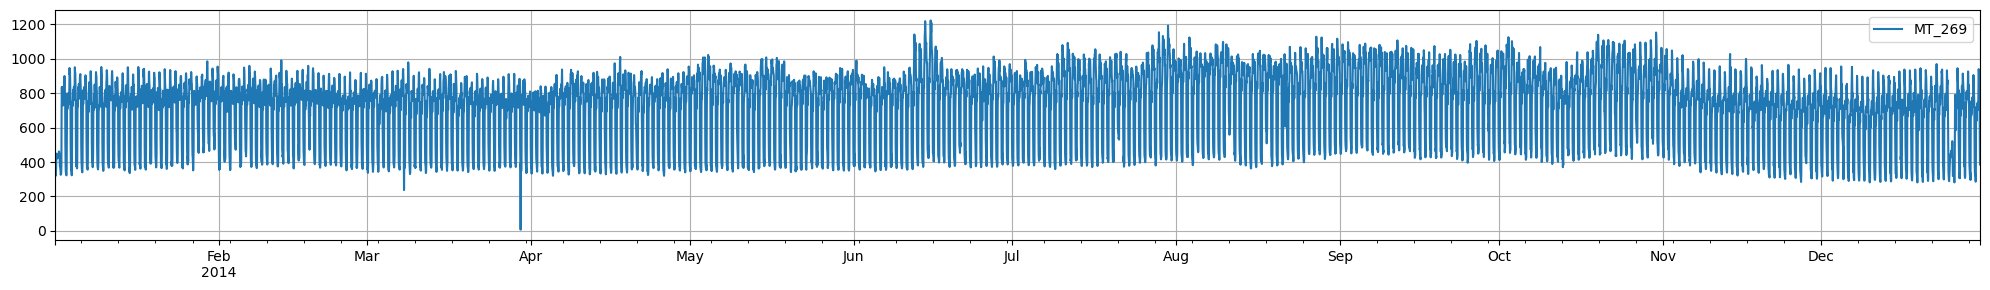

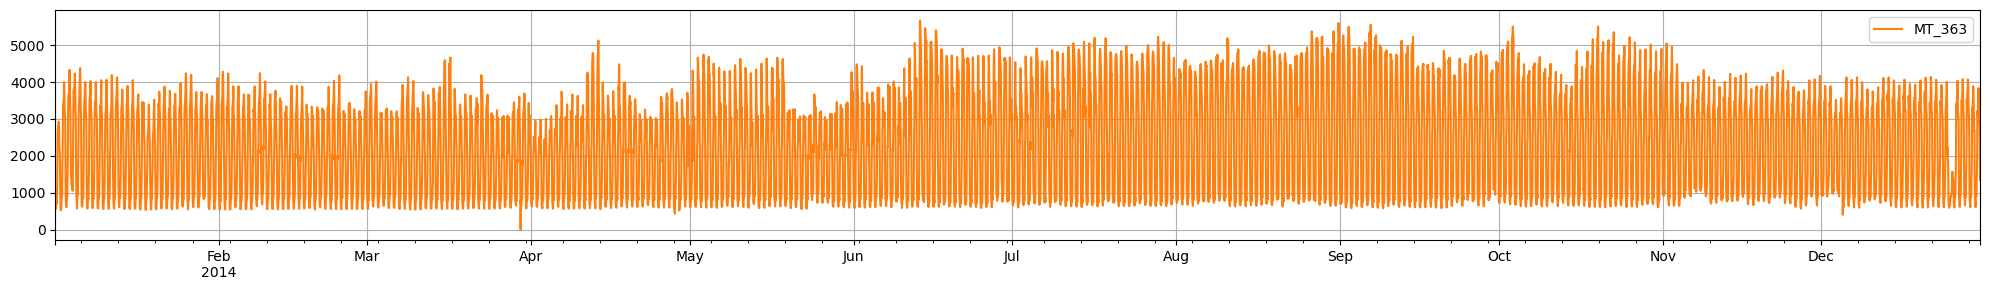

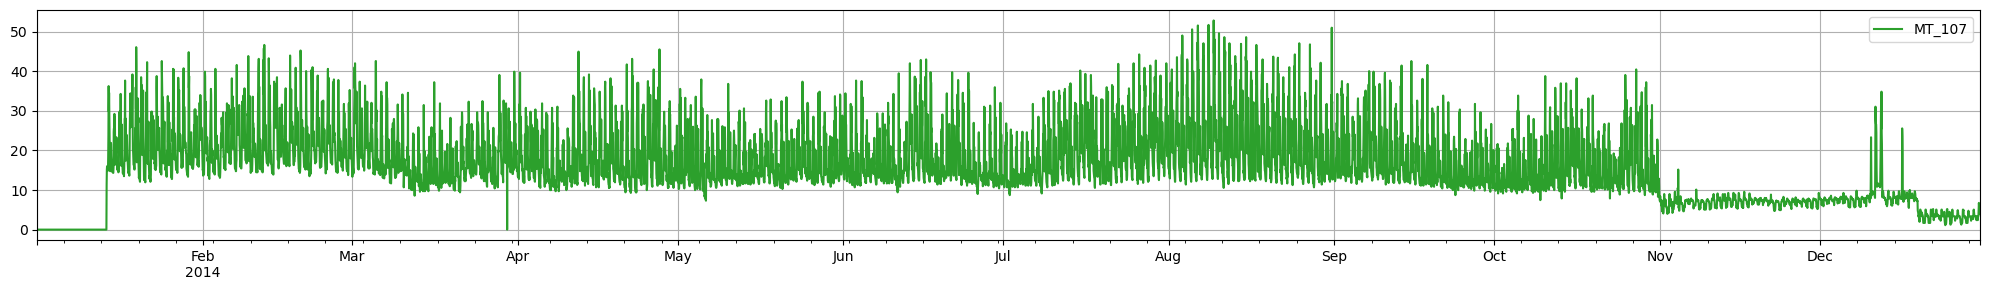

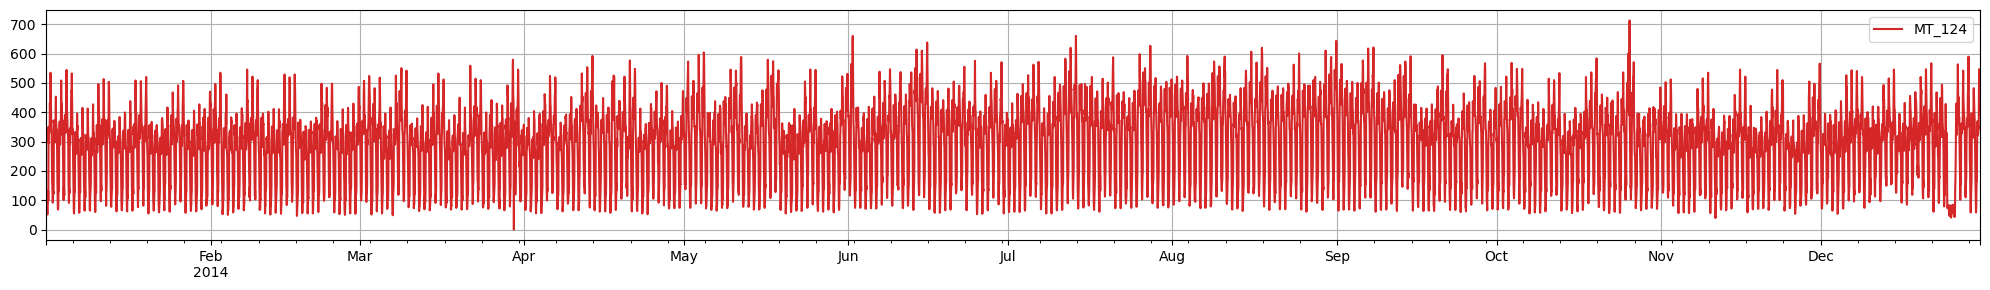

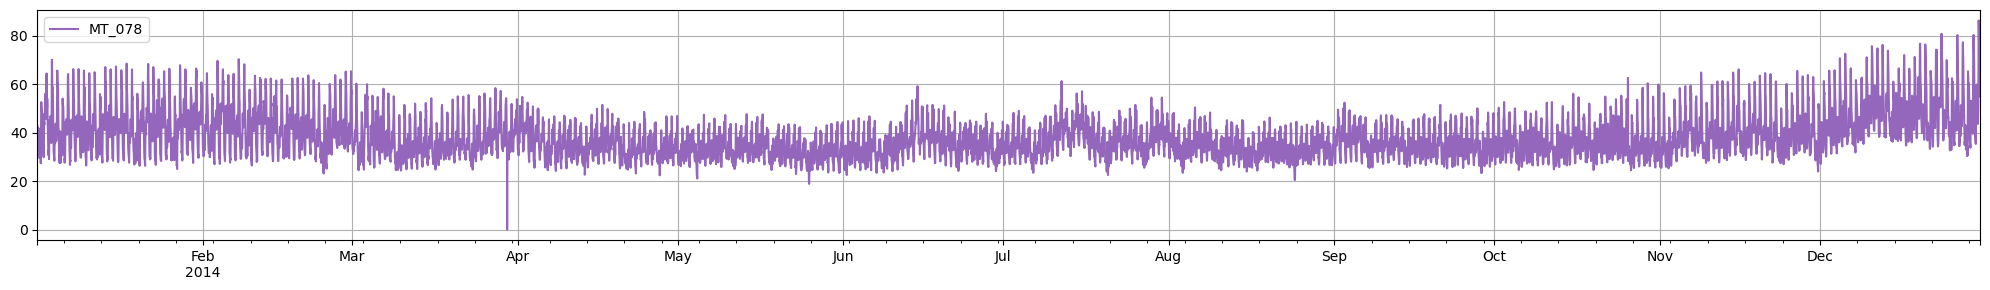

In [133]:
# show time series in the GluonTS dataset
for i, entry in enumerate(islice(ts_dataset, MAX_TS_TO_DISPLAY)):
    to_pandas(entry).plot(label=entry['item_id'], color=colors[i % len(colors)]) 
    plt.legend()
    plt.tight_layout()
    plt.show()

In [134]:
print(f'The GluonTS dataset contains {len(ts_dataset)} individual time series from {start_training_date} to {end_dataset_date}')

The GluonTS dataset contains 10 individual time series from 2014-01-01 00:00:00 to 2014-12-31 00:00:00


### Split and prepare test instances

For training and test you split data in multiple rolling windows starting from the end of the training dataset. You can choose the number of windows and whether windows overlap with each other.

In [139]:
# set backtest parameters
NUM_WINDOWS = 4 # number of rolling windows for backtest
# distance between windows, set to:
# < prediction_length for overlapping windows
# = prediction length for adjucent windows 
# > prediction_length for non overapping and non-adjucent windows
DISTANCE = prediction_length

# set the training-testing split date
end_training_date = pd.Period(end_dataset_date, freq=freq) - NUM_WINDOWS*prediction_length

In [140]:
train_ds, test_template = DateSplitter(date=end_training_date).split(ts_dataset)
test_pairs = test_template.generate_instances(
    prediction_length=prediction_length,
    windows=NUM_WINDOWS,
    distance=DISTANCE,
)

print(f"The dataset is splitted in {len(train_ds)} training datasets and {len(test_pairs)} test pairs. Training end is {end_training_date}")

The dataset is splitted in 10 training datasets and 40 test pairs. Training end is 2014-12-03 00:00


In [141]:
plot_dataset_splitting(ts_dataset, train_ds, test_pairs)

NameError: name 'plot_dataset_splitting' is not defined

### Train models

Now you're ready to train models. To demonstrate some built-in GluonTS algorithms you going to train the following models:

- [`SimpleFeedForward`](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/simple_feedforward/_estimator.py)
- [`NBEATS`](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/n_beats/_estimator.py), [paper](https://openreview.net/forum?id=r1ecqn4YwB)
- [`DeepAR`](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/deepar/_estimator.py), [paper](https://doi.org/10.1016/j.ijforecast.2019.07.001) 
- [`GaussianProcess`](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/gp_forecaster/_estimator.py)
- [`TemporalFusionTransformer`](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/tft/_estimator.py), [paper](https://doi.org/10.1016/j.ijforecast.2021.03.012)
- [`MQCNN`](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/seq2seq/_mq_dnn_estimator.py), [paper](https://arxiv.org/abs/1711.11053)

To compare performance of these models you're going to use statistical models like [`Seasonal Naive`](https://otexts.com/fpp2/simple-methods.html#seasonal-na%C3%AFve-method), [`Prophet`](https://facebook.github.io/prophet/), and [`NTPS`](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/model/npts/_predictor.py) as a baseline.

You can experiment with other [available models](https://ts.gluon.ai/stable/getting_started/models.html) on your own using the code in this notebook.

In [138]:
# remove an item from this list if you don't want to train that model
estimators_to_train = [
    'SimpleFeedForward', 
    'NBEATS', 
    'DeepAR',
    'GaussianProcess', 
    'TemporalFusionTransformer', 
    'MQCNN', 
]

<div style="border: 4px solid coral; text-align: left; margin: auto;">
<b>Important considerations</b><br/>
1. This example is not production-grade model training<br/>
2. All estimators are trained with default hyperparameters which might not be the optimal configuration<br/>
3. All training is limited to 8 epochs which might not yield the most optimal model<br/>
4. This notebook uses CPU-only MXNet implementation of all shown neural network models<br/>
5. In a real-world use case you're going to use an ensemble of several models rather than a single model<br/>
6. In a real-world use case you might run a hyperparameter optimization as well<br/>
</div>

In [ ]:
NUM_EPOCHS = 8
trainer_hyperparameters = {
    "ctx":"cpu",
    "epochs":NUM_EPOCHS,
    "learning_rate":01e-3,
    "clip_gradient":10,
    "weight_decay":1e-8,
    "num_batches_per_epoch":100,
}

# same trainer for all models
trainer = Trainer(**trainer_hyperparameters)

In [ ]:
estimators = {}
model_hyperparameters = {
    "freq":freq,
    "prediction_length":prediction_length,
    "context_length":4*prediction_length,
    "trainer":trainer,
}

for e in estimators_to_train:
    if e == 'SimpleFeedForward':
        estimators[e] = SimpleFeedForwardEstimator(
            num_hidden_dimensions=[10],
            prediction_length=prediction_length,
            context_length=4*prediction_length,
            trainer=trainer
        )
    elif e == 'NBEATS':
        estimators[e] = NBEATSEstimator(
            **model_hyperparameters,
            loss_function='MAPE',
            num_stacks=30,
            widths=[512],
            num_blocks=[1],
        )
    elif e == 'DeepAR':
        estimators[e] = DeepAREstimator(
            **model_hyperparameters,
        )
    elif e == 'GaussianProcess':
        estimators[e] = GaussianProcessEstimator(
            **model_hyperparameters,
            cardinality=len(train_ds),
        )
    elif e == 'TemporalFusionTransformer':
        estimators[e] = TemporalFusionTransformerEstimator(
            **model_hyperparameters,
        )
    elif e == 'MQCNN':
        estimators[e] = MQCNNEstimator(
            **model_hyperparameters,
        )
    elif e == 'MQRNN':
        estimators[e] = MQRNNEstimator(
            **model_hyperparameters,
        )
    else:
        continue

print(f'Configured estimators: {[k for k in estimators.keys()]}')

<div class="alert alert-info">
With six given estimators and 10 time series the training takes about <b>60 minutes</b>. You can take only a subset of estimators to reduce training time.
</div>

In [ ]:
print(f'Training {len(estimators.keys())} estimators on {len(train_ds)} time series.')
print(f'Estimators: {[k for k in estimators.keys()]}')

# train all estimators and store predictors in a dict
predictors = {
    n:e.train(train_ds) for n, e in estimators.items()
}

# add statistical models that don't need training for a baseline
predictors['SeasonalNaive'] = SeasonalNaivePredictor(prediction_length=prediction_length, season_length=24)
predictors['Prophet'] = ProphetPredictor(prediction_length=prediction_length)
predictors['NPTS'] = NPTSPredictor(prediction_length=prediction_length, context_length=4*prediction_length)

### Predict and visualize
Having all predictors you can generate forecasts for each test interval.

In [ ]:
print(f"Running inference for {len(predictors.keys())} predictors on {len(test_pairs)} test datasets: {NUM_WINDOWS} rolling windows*{len(ts_dataset)} time series")
print(f'Predictors: {[k for k in predictors.keys()]}')

# generate forecast for each test pair and each predictor and save to a dict
forecasts_all = {
    n:list(p.predict(test_pairs.input, num_samples=20)) for n, p in predictors.items()
}

# ground truth
labels = [to_pandas(l) for l in test_pairs.label]

In [ ]:
def visualize_predictions(
    item_id,
    original_dataset, # GluonTS PandasDataset
    forecasts, # iterator with predicted forecasts
    labels, # test_pairs.label iterator
    prediction_length,
    history_length, # how much of history are displayed
    c_interval=0.9, # confidence interval for probabilistic predictions
):
    # Get historical data, predictions, and label for the specific item_id
    historical_ts = to_pandas([e for e in original_dataset if e['item_id'] == item_id][0])
    item_forecasts = [f for f in forecasts if f.item_id == item_id]
    item_labels = [to_pandas(l) for l in labels if l['item_id'] == item_id]
    
    # Calculate the number of rows needed for the grid
    n_forecasts = len(item_forecasts)
    n_cols = 2
    n_rows = (n_forecasts +1) // n_cols
    
    # Create figure for historical data
    fig_hist, ax_hist = plt.subplots(figsize=(15, 3))
    plt.plot(historical_ts[-history_length:].to_timestamp(), color='b', label='Historical')
    ax_hist.set_title(f'Historical time series: {item_id}')
    ax_hist.legend()
    plt.tight_layout()
    
    # Create figure for forecasts
    fig_forecasts, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes]
    
    # Plot each forecast
    for idx, (label, forecast) in enumerate(zip(item_labels, item_forecasts)):
        ax = axes[idx]
        
        # Plot ground truth
        ax.plot(label.to_timestamp(), color='g', label='Ground truth')
        
        # Plot forecast with confidence interval
        forecast.plot(ax=ax, intervals=(c_interval,), show_label=True, color='r')
        
        ax.set_title(f'Prediction interval {idx}, start: {forecast.start_date}')
    
    # Remove empty subplots if any
    for idx in range(len(item_forecasts), len(axes)):
        fig_forecasts.delaxes(axes[idx])
    
    fig_forecasts.legend(['Ground truth', 'Predicted median', f'{c_interval*100:.0f}% confidence interval'], 
                        loc='upper center', 
                        bbox_to_anchor=(0.5, 1.0),
                        ncol=3,  # Display legend items in 3 columns
                        bbox_transform=fig_forecasts.transFigure)
    
    plt.tight_layout()
    # Adjust layout to account for the legend
    plt.subplots_adjust(top=0.85, hspace=0.5)
    plt.show()

In the following interactive visualization you can display historical data, predictions and ground truth for each evaluation window for a specific time series.

In [ ]:
style = {"description_width": "initial"}
item_ids = [e['item_id'] for e in ts_dataset]

In [ ]:
@interact_manual(
    model=Dropdown(options=list(forecasts_all.keys()), description='Model:'),
    item_id=Select(options=item_ids, value=item_ids[0], rows=5, style=style, description='Item id:'),
)
def plot_interact(model, item_id):
    visualize_predictions(
        item_id, 
        ts_dataset, 
        forecasts_all[model],
        test_pairs.label,
        prediction_length,
        NUM_WINDOWS*prediction_length
    )

If you'd like to compare performance across models and compare models per metric, run the following cells to save the results to a file and open the notebook [`lab6_results`](../lab6_results.ipynb) for the analysis.

### Evaluate predictions

In [ ]:
print(f"Scoring {len(forecasts_all.keys())} forecasts on {len(test_pairs)} test pairs: {NUM_WINDOWS} rolling windows*{len(ts_dataset)} time series")
print(f'Predictors: {[k for k in predictors.keys()]}')

evaluator = Evaluator(quantiles=(np.arange(10) / 10.0)[1:])

backtest_scores = []

# calculate metrics for all predictors
for n, f in forecasts_all.items():
    agg_metrics, item_metrics = evaluator(
        labels, 
        f,
    )
    backtest_scores.append({'model':n, 'agg_metrics':agg_metrics, 'item_metrics':item_metrics})

In [ ]:
style = {"description_width": "initial"}
item_ids = backtest_scores[0]['item_metrics']['item_id'].unique()
metrics = backtest_scores[0]['item_metrics'].columns[2:].tolist()

In [ ]:
@interact_manual(
    model=Dropdown(options=list(forecasts_all.keys()), description='Model:'),
    metric=Select(options=metrics, value=metrics[0], rows=20, style=style, description='Metric:'),
)
def plot_interactive(model, metric):
    agg_metrics, item_metrics = [(m['agg_metrics'], m['item_metrics']) for m in backtest_scores if m['model'] == model][0]

    visualize_item_metric(item_metrics, metric)
    print(f'Aggregated metrics for {model} model:\n{json.dumps(agg_metrics, indent=2)}')

#### Save the model performance to a file

In [ ]:
experiment_prefix = "gluonts"

In [ ]:
os.makedirs("../model-performance", exist_ok=True)

In [ ]:
def get_metrics_df(
    model_metrics: dict,
    experiment_name: str,
    timestamp=strftime("%Y%m%d-%H%M%S", gmtime()),
) -> pd.DataFrame:
    model_metrics_df = pd.DataFrame.from_dict(model_metrics, orient='index', columns=['value']).reset_index().rename(columns={'index': 'metric_name'})
    model_metrics_df['experiment'] = experiment_name
    model_metrics_df['timestamp'] = timestamp
    model_metrics_df = model_metrics_df[['timestamp', 'metric_name', 'value', 'experiment']].dropna(subset=['value'])

    # print(model_metrics_df)
    return model_metrics_df

In [ ]:
# construct a DataFrame with all metrics for all models
model_metrics_df = pd.concat([
    get_metrics_df(
        s['agg_metrics'],
        f"{experiment_prefix}-{s['model']}-{freq}-{len(ts_dataset)}-{len(next(iter(ts_dataset))['target'])}-bt{NUM_WINDOWS}",
    ) for s in backtest_scores
])

model_metrics_df

In [ ]:
# save the metrics df to the file
experiment_name = f"{experiment_prefix}-{freq}-{len(ts_dataset)}-{len(next(iter(ts_dataset))['target'])}-bt{NUM_WINDOWS}"

model_metrics_df.to_csv(
    f"../model-performance/{experiment_name}-{model_metrics_df['timestamp'].iloc[0]}.csv",
    index=False
)

---

## Optional: operationalizing GluonTS training and models

<div class="alert alert-info">
This section is <b>L300-400</b> level and assumes you're familiar with MLOps concepts, SageMaker features like pipelines, training jobs, and model registry. Completion time for this section is about <b>60 minutes</b>.
</div>

In [25]:
%load_ext autoreload
%autoreload 2

PyTorch implementation of [Temporal Fusion Transformer](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/torch/model/tft/estimator.py)

### Configure defaults of AWS infrastructure
Here you use a YAML configuration file to define the default values that are automatically passed to SageMaker APIs, for example as job parameters. It's especially convenient when you need to provide static parameters for infrastructure settings, such as VPC ids, Security Groups, KMS keys etc, or work with remote functions.

Refer to [Configuring and using defaults with the SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk) documentation for examples and more details.

Your GluonTS pipeline will use these `config.yaml` files.

In [27]:
# Print default location of configuration files
from platformdirs import site_config_dir, user_config_dir

#Prints the location of the admin config file
print(os.path.join(site_config_dir("sagemaker"), "config.yaml"))

#Prints the location of the user config file
print(os.path.join(user_config_dir("sagemaker"), "config.yaml"))

/etc/xdg/sagemaker/config.yaml
/home/sagemaker-user/.config/sagemaker/config.yaml


In [565]:
%%writefile config.yaml

SchemaVersion: '1.0'
SageMaker:
    PythonSDK:
        Modules:
            RemoteFunction:
                InstanceType: ml.m5.2xlarge
                Dependencies: ./requirements.txt
                IncludeLocalWorkDir: true
                CustomFileFilter:
                    IgnoreNamePatterns: # files or directories to ignore
                        - "*.ipynb" # all notebook files
                        - "*.md" # all markdown files
                        - "__pycache__"
                        - "*.zip"
                        - "*.gz"
                        - "LD2011_2014.*"
                        - "*local"
                        - "*logs"
                        - "*data"
                        - "*output"

Overwriting config.yaml


In [566]:
# copy the configuration file to user config file location
%mkdir -p {user_config_dir("sagemaker")}
%cp config.yaml {os.path.join(user_config_dir("sagemaker"), "config.yaml")}

### Prepare environment

Import required packages, create a `requirements.txt` file for SageMaker processing and training job, and create local source code directories for local mode execution.

In [654]:
from sagemaker.estimator import Estimator
from sagemaker.pytorch.estimator import PyTorch
from sagemaker.local import LocalSession

In [440]:
%%writefile requirements.txt
sentencepiece==0.1.99
lightning
gluonts>=0.16.0

Overwriting requirements.txt


In [441]:
!cp ./requirements.txt ./gluonts_pipeline/

In [442]:
!rm -rf ./gluonts_pipeline_local/
!mkdir -p ./gluonts_pipeline_local/

#### Configure for local mode
Amazon SageMaker Studio applications support the use of local mode to create estimators, processors, and pipelines. With local mode, you can test your scripts locally in JupyterLab before running them in SageMaker managed training or hosting environments. The local mode is a convenient way to quickly iterate over your training script in the notebook to ensure it works as intended.  Refer to [Local mode support in Amazon SageMaker Studio](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-updated-local.html) to understand which docker operations the Studio currently supports.

To use local mode in Studio applications, you must enable docker access for the Sagemaker domain and  install Docker into your JupyterLab space.

This section checks if docker access is enabled in the domain, installs Docker, and installs the `sagemaker[local]` extras from the sagemaker SDK.

In [494]:
# check that docker enabled in the SageMaker domain
docker_settings = boto3.client('sagemaker').describe_domain(DomainId=domain_id)['DomainSettings'].get('DockerSettings')
docker_enabled = False

if docker_settings:
    if docker_settings.get('EnableDockerAccess') in ['ENABLED']:
        print(f"The docker access is ENABLED in the domain {domain_id}")
        docker_enabled = True

if not docker_enabled:
    raise Exception(f"You must enable docker access in the domain to use Studio local mode")

The docker access is ENABLED in the domain d-mv9ybtbztu4a


<div class="alert alert-info">
If docker is not enabled, you need to enable the access following the instructions below. You may also skip the <b>Run and test pipeline steps locally</b> section and go directly to the <b>Construct a pipeline</b> section.
</div>

If you have the corresponding permissions in the notebook execution role, you can run the following code in a notebook:

```Python
import boto3

r = boto3.client('sagemaker').update_domain(
    DomainId=domain_id,
    DomainSettingsForUpdate={
        'DockerSettings': {
            'EnableDockerAccess':'ENABLED',
        }
    }
)
```

Alternatively run can run `aws sagemaker` CLI in the terminal:

```sh
aws sagemaker update-domain --domain-id <DOMAIN-ID> --domain-settings-for-update DockerSettings={EnableDockerAccess='ENABLED'}
```

For both options your execution role needs to have `sagemaker:UpdateDomain` permission.

#### Install Docker

In [ ]:
%%bash

# see https://docs.docker.com/engine/install/ubuntu/#install-using-the-repository
sudo apt-get update
sudo apt-get install -y ca-certificates curl
sudo install -m 0755 -d /etc/apt/keyrings
sudo curl -fsSL https://download.docker.com/linux/ubuntu/gpg -o /etc/apt/keyrings/docker.asc
sudo chmod a+r /etc/apt/keyrings/docker.asc

# Add the repository to Apt sources:
echo \
  "deb [arch=$(dpkg --print-architecture) signed-by=/etc/apt/keyrings/docker.asc] https://download.docker.com/linux/ubuntu \
  $(. /etc/os-release && echo "$VERSION_CODENAME") stable" | \
  sudo tee /etc/apt/sources.list.d/docker.list > /dev/null
sudo apt-get update

## Currently only Docker version 20.10.X is supported in Studio: see https://docs.aws.amazon.com/sagemaker/latest/dg/studio-updated-local.html
# pick the latest patch from:
# apt-cache madison docker-ce | awk '{ print $3 }' | grep -i 20.10
VERSION_STRING=5:20.10.24~3-0~ubuntu-jammy
sudo apt-get install docker-ce-cli=$VERSION_STRING docker-compose-plugin -y

# validate the Docker Client is able to access Docker Server at [unix:///docker/proxy.sock]
docker version

In [ ]:
%pip install -q sagemaker[local]

### Upload the raw dataset to S3

In [31]:
# set S3 urls for input and output data
s3_input_data_prefix = f's3://{s3_bucket}/{s3_prefix}/data/raw'
s3_output_data_prefix = f's3://{s3_bucket}/{s3_prefix}/data/output'

In [32]:
# remove all previous datasets on S3
!aws s3 rm s3://{s3_bucket}/{s3_prefix}/data/ --recursive

delete: s3://sagemaker-us-east-1-906545278380/gluonts-demo-notebook/data/raw/LD2011_2014.txt.zip


In [34]:
# copy the original zip file with the dataset to S3
!aws s3 cp {extract_to_path}/{dataset_zip_file_name} {s3_input_data_prefix}/

upload: ../data/LD2011_2014.txt.zip to s3://sagemaker-us-east-1-906545278380/gluonts-demo-notebook/data/raw/LD2011_2014.txt.zip


In [495]:
# validate that the dataset is copied on S3
!aws s3 ls s3://{s3_bucket}/{s3_prefix}/data/ --recursive

2024-11-16 12:00:51     262137 gluonts-demo-notebook/data/output/test/test.jsonl.gz
2024-11-16 12:00:51     242273 gluonts-demo-notebook/data/output/train/train.jsonl.gz
2024-11-15 14:16:22  261335609 gluonts-demo-notebook/data/raw/LD2011_2014.txt.zip


### Set parameters

Set values for parameters passed to the pipeline steps.

In [698]:
# portion of the whole dataset used
data_start = pd.Timestamp('2014-01-01')
data_end = pd.Timestamp('2014-12-31')

# hyperparameters for training
hyperparameters = {
    "epochs":8,
    "freq":freq,
    "prediction_length":prediction_length,
    "context_length":4*prediction_length,
    "quantiles":','.join(str(x) for x in (np.arange(10) / 10.0)[1:]),
    "backtest_windows":4,
    "num_samples":20,
}

# define metrics which should be collected by SageMaker
metric_definitions = [
    {'Name':'train_loss', 'Regex':'train_loss=([0-9\.]+)'},
    {'Name':'test_MSE', 'Regex':'test_MSE=([0-9\.]+)'},
    {'Name':'test_MAPE', 'Regex':'test_MAPE=([0-9\.]+)'},
    {'Name':'test_sMAPE', 'Regex':'test_sMAPE=([0-9\.]+)'},
    {'Name':'test_RMSE', 'Regex':'test_RMSE=([0-9\.]+)'},
    {'Name':'test_mean_wQuantileLoss', 'Regex':'test_mean_wQuantileLoss=([0-9\.]+)'},
    {'Name':'test_mean_absolute_QuantileLoss', 'Regex':'test_mean_absolute_QuantileLoss=([0-9\.]+)'},
]

# where to store training artefacts
s3_output_train_prefix = f's3://{s3_bucket}/{s3_prefix}/train/output'

# model package group name in the Model Registry
model_package_group_name = 'gluonts-tft-local'

### Run and test pipeline steps locally

In this section you develop and test each step of the workflow locally before combining all tested steps into a pipeline.

#### Preprocessing step

In [699]:
# Python function code is in the local files
from gluonts_pipeline.preprocess import preprocess

In [700]:
r_preprocess = preprocess(
    input_data_s3_path = f'{s3_input_data_prefix}/{dataset_zip_file_name}',
    output_s3_prefix=s3_output_data_prefix,
    freq=freq,
    prediction_length=prediction_length,
    data_start=data_start,
    data_end=data_end,
    backtest_windows=4,
    sample_size=10,  # set to 0 to use the full dataset with 370 series
)
r_preprocess

Unzipping LD2011_2014.txt.zip
Load dataset from ./data/LD2011_2014.txt and resample to 1h frequency
Get a sample of 10 time series out of the full dataset
--------------------------------------------------------
The test dataset contains 10 time series
The test dataset starts 2014-01-01 01:00:00 and ends 2014-12-31 01:00 and contains 8736 data points
The train dataset starts 2014-01-01 01:00 and ends 2014-12-03 01:00 and contains 8064 data points
The backtest contains 672 data points and has 4.0 windows of 168 length
--------------------------------------------------------
Upload train and test datasets to s3://sagemaker-us-east-1-906545278380/gluonts-demo-notebook/data/output/train/train.jsonl.gz and s3://sagemaker-us-east-1-906545278380/gluonts-demo-notebook/data/output/test/test.jsonl.gz
### Data processing completed. Exiting.


{'train_data': 's3://sagemaker-us-east-1-906545278380/gluonts-demo-notebook/data/output/train/train.jsonl.gz',
 'test_data': 's3://sagemaker-us-east-1-906545278380/gluonts-demo-notebook/data/output/test/test.jsonl.gz'}

In [701]:
# validate that the dataset is copied on S3
!aws s3 ls {s3_output_data_prefix} --recursive

2024-11-17 16:16:18     311720 gluonts-demo-notebook/data/output/test/test.jsonl.gz
2024-11-17 16:16:17     290109 gluonts-demo-notebook/data/output/train/train.jsonl.gz


#### Training step

This section demonstrates two options for implementing GluonTS training. 

Option 1 is to run a custom training script as a remote function using `@step` decorator. Option 2 is to use a [SageMaker SDK framework for PyTorch](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html) and leverage the built-in [SageMaker Deep Learning Containers (DLC)](https://github.com/aws/deep-learning-containers/blob/master/available_images.md).

This section uses Option 2 because it requires less effort for training artefact management and allows model deployment with one line of code from a trained estimator.

In [703]:
from gluonts_pipeline.train_step import train

In [704]:
# input datasets for training
# these datasets are prepared and uploaded to S3 by the preprocessing step
training_inputs = {
    'train': r_preprocess['train_data'],
    'test': r_preprocess['test_data'],
}

In [705]:
# Option 1: use local training script and then @step decorator for the pipeline step
# This code is given for your reference
# r_train = train(
#     train_data_s3_path=r_preprocess['train_data'],
#     test_data_s3_path=r_preprocess['test_data'],
#     output_s3_prefix=s3_output_train_prefix,
#     hyperparameters=hyperparameters,
# )
# r_train

In [706]:
# copy scripts and requirements.txt to the dedicated directory
!cp -rf ./gluonts_pipeline/* ./gluonts_pipeline_local

In [707]:
# create a local session
LOCAL_SESSION = LocalSession()
LOCAL_SESSION.config = {'local': {'local_code': True}}  # Ensure full code locality, see: https://sagemaker.readthedocs.io/en/stable/overview.html#local-mode

In [708]:
# Option 2: use a PyTorch estimator class
# note use of 'local' as instance_type parameter
tft_estimator_local = PyTorch(
    entry_point='train.py',
    source_dir='gluonts_pipeline_local',
    framework_version="2.3",  
    py_version='py311',
    hyperparameters=hyperparameters,
    role=sm_role,
    instance_count=1,
    instance_type='local',
    output_path=s3_output_train_prefix,
    base_job_name="gluonts-pipeline-training",
    sagemaker_session=LOCAL_SESSION,
)

In [ ]:
# run training in a container locally in the notebook
tft_estimator_local.fit(training_inputs)

In [710]:
# validate that the train artefacts are uploaded to S3
!aws s3 ls {s3_output_train_prefix}/{tft_estimator_local._current_job_name} --recursive

2024-11-17 16:19:38     466944 gluonts-demo-notebook/train/output/gluonts-pipeline-training-2024-11-17-16-17-15-340/output/model.tar.gz
2024-11-17 16:19:39       9054 gluonts-demo-notebook/train/output/gluonts-pipeline-training-2024-11-17-16-17-15-340/output/output.tar.gz


In [711]:
# download artefacts to the local volume
!aws s3 cp {s3_output_train_prefix}/{tft_estimator_local._current_job_name}/output . --recursive

download: s3://sagemaker-us-east-1-906545278380/gluonts-demo-notebook/train/output/gluonts-pipeline-training-2024-11-17-16-17-15-340/output/output.tar.gz to ./output.tar.gz
download: s3://sagemaker-us-east-1-906545278380/gluonts-demo-notebook/train/output/gluonts-pipeline-training-2024-11-17-16-17-15-340/output/model.tar.gz to ./model.tar.gz


In [712]:
!tar -xvf ./output.tar.gz -C output/

data/
data/agg_metrics.json
data/item_metrics.csv.gz
success


In [713]:
# display aggregated test metrics
with open('output/data/agg_metrics.json', 'r') as f:
    agg_metrics = json.load(f)

agg_metrics

{'MSE': 1515.373693877175,
 'abs_error': 151867.28021240234,
 'abs_target_sum': 807967.3184814453,
 'abs_target_mean': 120.23323191688173,
 'seasonal_error': nan,
 'MASE': nan,
 'MAPE': 0.25170774658521017,
 'sMAPE': 0.21572309249923344,
 'MSIS': nan,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 66075.61940164566,
 'Coverage[0.1]': 0.17247023809523807,
 'QuantileLoss[0.2]': 101229.53069677352,
 'Coverage[0.2]': 0.21711309523809522,
 'QuantileLoss[0.3]': 125450.47707848549,
 'Coverage[0.3]': 0.2861607142857143,
 'QuantileLoss[0.4]': 144762.5583759308,
 'Coverage[0.4]': 0.35922619047619053,
 'QuantileLoss[0.5]': 151867.2815759182,
 'Coverage[0.5]': 0.39955357142857145,
 'QuantileLoss[0.6]': 151603.58082580566,
 'Coverage[0.6]': 0.47648809523809527,
 'QuantileLoss[0.7]': 144133.08725395202,
 'Coverage[0.7]': 0.5796130952380952,
 'QuantileLoss[0.8]': 118732.25027418137,
 'Coverage[0.8]': 0.6867559523809523,
 'QuantileLoss[0.9]': 78398.91710491179,
 'Coverage[0.9]': 0.80148809523

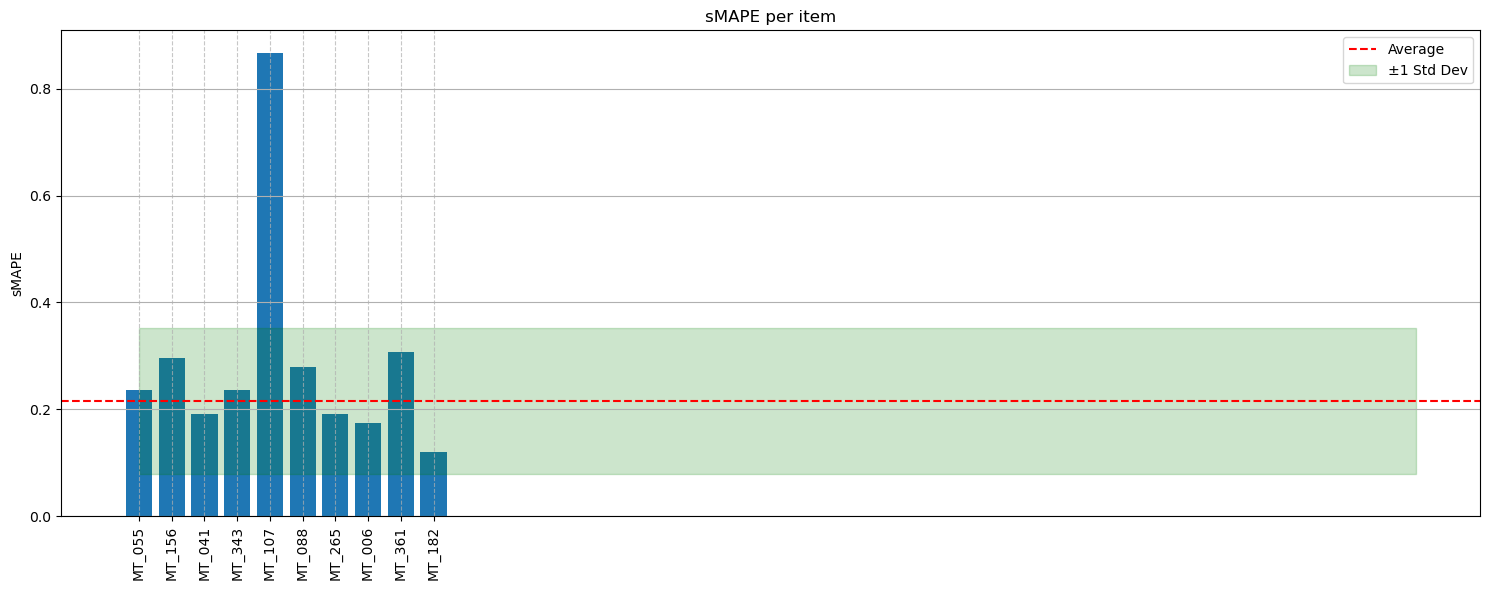

In [714]:
# display item-level metrics
item_metrics = pd.read_csv("output/data/item_metrics.csv.gz", compression="gzip")
visualize_item_metric(item_metrics, 'sMAPE')

In [715]:
# predictor_deserialized = Predictor.deserialize(Path("./output/model")) 

In [716]:
# forecasts = predictor_deserialized.predict(test_pairs.input, 20)
# evaluator = Evaluator(quantiles=(np.arange(10) / 10.0)[1:])
# evaluator([to_pandas(l) for l in test_pairs.label], forecasts)

In [717]:
# You can also run the training job remotely on a specified instance type
# tft_estimator = PyTorch(
#     entry_point='train.py',
#     source_dir='gluonts_pipeline',
#     framework_version="2.3",  
#     py_version='py311',
#     hyperparameters=hyperparameters,
#     role=sm_role,
#     instance_count=1,
#     instance_type='ml.g5.4xlarge',
#     output_path=s3_output_train_prefix,
#     base_job_name="gluonts-pipeline-training",
#     metric_definitions=metric_definitions,
# )

# tft_estimator.fit(training_inputs, wait=False)

#### Model registration step

This step registers a new trained model version in the SageMaker model registry within a [model package group](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry-model-group.html). This step is implemented as a local Python function that runs remotely during execution of the pipeline.

If you don't have a completed training job, skip this step and go to **Construct a pipeline**. The model registration implementation requires a completed training job to attach an estimator and to register a model.

In [718]:
from gluonts_pipeline.register import register

In [720]:
# r_register = register(
#     training_job_name=<TRAINING JOB NAME>,
#     model_package_group_name=model_package_group_name,
# )
# r_register

### Construct a pipeline
After local testing you can use the same Python code without any changes to construct a pipeline.

The next cell creates a pipeline with previously developed and tested steps.

You don't need to manually define an ordering of the steps, as SageMaker automatically derives the processing flow based on data dependencies between pipeline's steps. You also don't need to manage transfer of artifacts and datasets from one pipeline's step to another, because SageMaker automatically takes care of the data flow.

In [728]:
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.pipeline_context import PipelineSession
from sagemaker.workflow.functions import Join
from sagemaker.workflow.steps import (
    TrainingStep, 
    CacheConfig
)
from sagemaker.workflow.parameters import (
    ParameterInteger, 
    ParameterFloat, 
    ParameterString, 
    ParameterBoolean
)
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.conditions import ConditionLessThanOrEqualTo
from sagemaker.workflow.fail_step import FailStep
from sagemaker.workflow.function_step import step
from sagemaker.workflow.pipeline_definition_config import PipelineDefinitionConfig 

#### Define pipeline parameters

In [723]:
timestamp = strftime('%d-%H-%M-%S', gmtime())
pipeline_name = f'gluonts-pipeline-{timestamp}'
model_package_group_name = f'gluonts-tft-{timestamp}'

processing_instance_type = 'ml.c5.4xlarge'
training_instance_type = 'ml.g5.4xlarge'

pipeline_parameters = {
    'processing_instance_type':ParameterString(name='processing_instance_type', default_value=processing_instance_type),
    'training_instance_type':ParameterString(name='training_instance_type', default_value=training_instance_type),
    'input_data_s3_path':ParameterString(name='input_data_s3_path', default_value=f'{s3_input_data_prefix}/{dataset_zip_file_name}'),
    's3_output_data_prefix':ParameterString(name='s3_output_data_prefix', default_value=s3_output_data_prefix),
    's3_output_train_prefix':ParameterString(name='s3_output_train_prefix', default_value=s3_output_train_prefix),
    'freq':ParameterString(name='freq', default_value=freq),
    'prediction_length':ParameterInteger(name='prediction_length', default_value=prediction_length),
    'data_start':ParameterString(name='data_start', default_value=str(data_start)),
    'data_end':ParameterString(name='data_end', default_value=str(data_end)),
    'backtest_windows':ParameterInteger(name='backtest_windows', default_value=4),
    'sample_size':ParameterInteger(name='sample_size', default_value=10),
    'mean_wQL_score_threshold':ParameterFloat(name='mean_wQL_score_threshold', default_value=0.2),
    'model_package_group_name':ParameterString(name='model_package_group_name', default_value=model_package_group_name),
}

#### Define and upsert the pipeline

Now create the pipeline. If a pipeline with the same name already exits, SageMaker will update it.

You need to pass only the last step to Pipeline constructor. The SDK automatically builds a pipeline DAG based on data dependencies between steps. Refer to the [Developer Guide](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-overview.html) for more details.

In [724]:
from gluonts_pipeline.preprocess import preprocess
from gluonts_pipeline.train_step import train
from gluonts_pipeline.register import register

In [729]:
# preprocess data step
step_preprocess = step(
    preprocess, 
    instance_type=pipeline_parameters['processing_instance_type'],
    keep_alive_period_in_seconds=1800,
)(
    input_data_s3_path=pipeline_parameters['input_data_s3_path'],
    output_s3_prefix=pipeline_parameters['s3_output_data_prefix'],
    freq=pipeline_parameters['freq'],
    prediction_length=pipeline_parameters['prediction_length'],
    data_start=pipeline_parameters['data_start'],
    data_end=pipeline_parameters['data_end'],
    backtest_windows=pipeline_parameters['backtest_windows'],
    sample_size=pipeline_parameters['sample_size'],  
)

# training step with PyTorch estimator
step_train = TrainingStep(
    name='train',
    step_args=PyTorch(
        entry_point='train.py',
        source_dir='gluonts_pipeline',
        framework_version="2.3",  
        py_version='py311',
        hyperparameters=hyperparameters,
        role=sm_role,
        instance_count=1,
        instance_type=pipeline_parameters['training_instance_type'],
        output_path=pipeline_parameters['s3_output_train_prefix'],
        base_job_name="gluonts-pipeline-training",
        metric_definitions=metric_definitions,
        sagemaker_session=PipelineSession(),
    ).fit({'train':step_preprocess['train_data'], 'test':step_preprocess['test_data']}),
    cache_config=CacheConfig(enable_caching=True, expire_after="P30d"),
)

# This code if you use the training script with @step decorator
# step_train = step(
#     train,
#     instance_type=pipeline_parameters['training_instance_type'],
#     keep_alive_period_in_seconds=1800,
# )(
#     train_data_s3_path=step_preprocess['train_data'],
#     test_data_s3_path=step_preprocess['test_data'],
#     output_s3_prefix=pipeline_parameters['s3_output_train_prefix'],
#     hyperparameters=hyperparameters,
# )

# register model step
step_register = step(
    register, 
    keep_alive_period_in_seconds=1800,
)(
    training_job_name=step_train.properties.TrainingJobName,
    model_package_group_name=pipeline_parameters['model_package_group_name'],
)

# fail the pipeline execution step
step_fail = FailStep(
    name='fail',
    error_message=Join(
        on=" ", 
        values=["Execution failed due to mean_wQL > ", pipeline_parameters['mean_wQL_score_threshold']]
    ),
)

# check if the test score acceptable
step_condition = ConditionStep(
    name='check-mean-wQL',
    conditions=[
        ConditionLessThanOrEqualTo(
            left=step_train.properties.FinalMetricDataList['test_mean_wQuantileLoss'].Value,
            right=pipeline_parameters['mean_wQL_score_threshold']
    )],
    if_steps=[step_register],
    else_steps=[step_fail],
)

# Create a pipeline object
pipeline = Pipeline(
    name=f"{pipeline_name}",
    parameters=[v for v in pipeline_parameters.values()],
    steps=[step_condition],
    pipeline_definition_config=PipelineDefinitionConfig(use_custom_job_prefix=True)
)

There are two additional steps in the pipeline.

**Condition step**  
The condition step checks the model performance score calculated in the training step and conditionally creates a model and registers it in the model registry, or stops and fails the pipeline execution.

**Fail step**  
A Pipelines [FailStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.fail_step.FailStep) stops the pipeline execution if the model performance metric doesn't meet the specified threshold.

Now create the pipeline. If a pipeline with the same name already exits, SageMaker will update it.

In [730]:
# Upsert operation serialize the function code, arguments, and other artefacts to S3 where it can be accessed during pipeline's runtime
pipeline.upsert(role_arn=sm_role)

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.Dependencies
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.InstanceType


2024-11-17 16:26:01,551 sagemaker.remote_function INFO     Uploading serialized function code to s3://sagemaker-us-east-1-906545278380/gluonts-pipeline-17-16-23-32/register-3382abaa-d4bb-4f57-8be1-aa6c10c17c1a/2024-11-17-16-25-59-608/function
2024-11-17 16:26:01,608 sagemaker.remote_function INFO     Uploading serialized function arguments to s3://sagemaker-us-east-1-906545278380/gluonts-pipeline-17-16-23-32/register-3382abaa-d4bb-4f57-8be1-aa6c10c17c1a/2024-11-17-16-25-59-608/arguments
2024-11-17 16:26:01,771 sagemaker.remote_function INFO     Copied dependencies file at './requirements.txt' to '/tmp/tmpfyhfq2d5/requirements.txt'
2024-11-17 16:26:01,794 sagemaker.remote_function INFO     Successfully uploaded dependencies and pre execution scripts to 's3://sagemaker-us-east-1-906545278380/gluonts-pipeline-17-16-23-32/register-3382abaa-d4bb-4f57-8be1-aa6c10c17c1a/2024-11-17-16-25-59-608/pre_exec_script_and_dependencies'
2024-11-17 16:26:01,797 sagemaker.remote_function INFO     Copied 

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.Dependencies
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns


2024-11-17 16:26:04,838 sagemaker.remote_function INFO     Uploading serialized function code to s3://sagemaker-us-east-1-906545278380/gluonts-pipeline-17-16-23-32/preprocess-06d5fd06-499d-481f-8318-cd2170b6152e/2024-11-17-16-25-59-608/function
2024-11-17 16:26:04,920 sagemaker.remote_function INFO     Uploading serialized function arguments to s3://sagemaker-us-east-1-906545278380/gluonts-pipeline-17-16-23-32/preprocess-06d5fd06-499d-481f-8318-cd2170b6152e/2024-11-17-16-25-59-608/arguments
2024-11-17 16:26:04,995 sagemaker.remote_function INFO     Copied dependencies file at './requirements.txt' to '/tmp/tmptvtsdv3b/requirements.txt'
2024-11-17 16:26:05,017 sagemaker.remote_function INFO     Successfully uploaded dependencies and pre execution scripts to 's3://sagemaker-us-east-1-906545278380/gluonts-pipeline-17-16-23-32/preprocess-06d5fd06-499d-481f-8318-cd2170b6152e/2024-11-17-16-25-59-608/pre_exec_script_and_dependencies'


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:906545278380:pipeline/gluonts-pipeline-17-16-23-32',
 'ResponseMetadata': {'RequestId': '0b128d1f-5f32-4c63-93d5-9ef597aca9ac',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '0b128d1f-5f32-4c63-93d5-9ef597aca9ac',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '96',
   'date': 'Sun, 17 Nov 2024 16:26:05 GMT'},
  'RetryAttempts': 0}}

To see the created pipeline in the Studio UI, click on the link constructed by the code cell below:

In [731]:
from IPython.display import HTML

# Show the pipeline link
display(
    HTML('<b>See <a target="top" href="https://studio-{}.studio.{}.sagemaker.aws/pipelines/{}/graph">the pipeline</a> in the Studio UI</b>'.format(
            domain_id, region, pipeline_name))
)

### Execute the pipeline

A pipeline execution takes about 20 minutes.

In [757]:
# this starts a pipeline execution
pipeline_execution = pipeline.start()
pipeline_execution.describe()

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:906545278380:pipeline/gluonts-pipeline-17-16-23-32',
 'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:906545278380:pipeline/gluonts-pipeline-17-16-23-32/execution/19016259ohlq',
 'PipelineExecutionDisplayName': 'execution-1731878506968',
 'PipelineExecutionStatus': 'Executing',
 'CreationTime': datetime.datetime(2024, 11, 17, 21, 21, 46, 899000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 11, 17, 21, 21, 46, 899000, tzinfo=tzlocal()),
 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:906545278380:user-profile/d-mv9ybtbztu4a/studio-user-ts-4b422b90',
  'UserProfileName': 'studio-user-ts-4b422b90',
  'DomainId': 'd-mv9ybtbztu4a',
  'IamIdentity': {'Arn': 'arn:aws:sts::906545278380:assumed-role/ts-workshop-domain-SageMakerExecutionRole-c2odofFHtcPA/SageMaker',
   'PrincipalId': 'AROA5GESPFWWKBTCQO5F6:SageMaker'}},
 'LastModifiedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:906545278380:user-profile/d-

In [735]:
# Uncomment if you would like to wait in the notebook until this execution completes
# pipeline_execution.wait() 
pipeline_execution.list_steps()

[{'StepName': 'register-3382abaa-d4bb-4f57-8be1-aa6c10c17c1a',
  'StepDisplayName': 'gluonts_pipeline.register.register',
  'StartTime': datetime.datetime(2024, 11, 17, 16, 41, 45, 782000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2024, 11, 17, 16, 49, 26, 778000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'TrainingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:906545278380:training-job/register-ryjtgkyyo5it-1gJ3wVmKjN'}},
  'AttemptCount': 1},
 {'StepName': 'check-mean-wQL',
  'StartTime': datetime.datetime(2024, 11, 17, 16, 41, 45, 283000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2024, 11, 17, 16, 41, 45, 452000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'Condition': {'Outcome': 'True'}},
  'AttemptCount': 1},
 {'StepName': 'train',
  'StartTime': datetime.datetime(2024, 11, 17, 16, 34, 59, 493000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2024, 11, 17, 16, 41, 44, 675000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  

You can see the pipeline execution in the Studio UI by clicking on the link constructed by the following code cell:

In [736]:
# Show the pipeline execution link
display(
    HTML('<b>See <a target="top" href="https://studio-{}.studio.{}.sagemaker.aws/pipelines/{}/executions/{}/graph">the pipeline execution</a> in the Studio UI</b>'.format(
            domain_id, region, pipeline_name, pipeline_execution.describe()['PipelineExecutionArn'].split('/')[-1]))
)

### Explore pipeline execution

After the pipeline execution completed, you have a trained model which is registered as a new model version in the specified model package group in the SageMaker Model Registry. You can also explore calculated model metrics and get any details on the training job.

In [738]:
# make sure the execution completed
pipeline_execution.wait()
assert pipeline_execution.describe()['PipelineExecutionStatus'] == 'Succeeded'

In [739]:
# Display all steps with StepStatus
pipeline_execution.list_steps()

[{'StepName': 'register-3382abaa-d4bb-4f57-8be1-aa6c10c17c1a',
  'StepDisplayName': 'gluonts_pipeline.register.register',
  'StartTime': datetime.datetime(2024, 11, 17, 16, 41, 45, 782000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2024, 11, 17, 16, 49, 26, 778000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'TrainingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:906545278380:training-job/register-ryjtgkyyo5it-1gJ3wVmKjN'}},
  'AttemptCount': 1},
 {'StepName': 'check-mean-wQL',
  'StartTime': datetime.datetime(2024, 11, 17, 16, 41, 45, 283000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2024, 11, 17, 16, 41, 45, 452000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'Condition': {'Outcome': 'True'}},
  'AttemptCount': 1},
 {'StepName': 'train',
  'StartTime': datetime.datetime(2024, 11, 17, 16, 34, 59, 493000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2024, 11, 17, 16, 41, 44, 675000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  

#### Explore training metrics

In [740]:
# Get training job name from the pipeline step properties
train_step = [s for s in pipeline_execution.list_steps() if s['StepName'] == 'train'][0]
training_job_name = train_step['Metadata']['TrainingJob']['Arn'].split('/')[-1]

# Attach an estimator object to the job
estimator = Estimator.attach(training_job_name)


2024-11-17 16:41:44 Starting - Starting the training job
2024-11-17 16:41:44 Pending - Preparing the instances for training
2024-11-17 16:41:44 Downloading - Downloading the training image
2024-11-17 16:41:44 Training - Training image download completed. Training in progress.
2024-11-17 16:41:44 Uploading - Uploading generated training model
2024-11-17 16:41:44 Completed - Training job completed


In [741]:
# Display training job metrics
estimator.training_job_analytics.dataframe()

,timestamp,metric_name,value
0,0.0,train_loss,26.875000
1,60.0,train_loss,20.925000
2,0.0,test_MSE,3156.750829
3,0.0,test_MAPE,0.202877
4,0.0,test_sMAPE,0.214075
5,0.0,test_RMSE,56.184970
6,0.0,test_mean_wQuantileLoss,0.135701
7,0.0,test_mean_absolute_QuantileLoss,169684.976686


In [674]:
# Get all job properties including S3 output prefix where training artefacts stored
job_description = boto3.client('sagemaker').describe_training_job(TrainingJobName=training_job_name)
s3_output_prefix = job_description['OutputDataConfig']['S3OutputPath']

In [742]:
# Display train artefacts uploaded to S3 by the training job
!aws s3 ls {s3_output_prefix}/{training_job_name} --recursive

2024-11-17 16:41:38          0 gluonts-demo-notebook/train/output/gluonts-pipeline-training-ryjtgkyyo5it-Rs8nyNPbcH/debug-output/training_job_end.ts
2024-11-17 16:41:37     468401 gluonts-demo-notebook/train/output/gluonts-pipeline-training-ryjtgkyyo5it-Rs8nyNPbcH/output/model.tar.gz
2024-11-17 16:41:37       8989 gluonts-demo-notebook/train/output/gluonts-pipeline-training-ryjtgkyyo5it-Rs8nyNPbcH/output/output.tar.gz
2024-11-17 16:41:38          0 gluonts-demo-notebook/train/output/gluonts-pipeline-training-ryjtgkyyo5it-Rs8nyNPbcH/profiler-output/framework/training_job_end.ts
2024-11-17 16:38:01     259212 gluonts-demo-notebook/train/output/gluonts-pipeline-training-ryjtgkyyo5it-Rs8nyNPbcH/profiler-output/system/incremental/2024111716/1731861360.algo-1.json
2024-11-17 16:38:00     621461 gluonts-demo-notebook/train/output/gluonts-pipeline-training-ryjtgkyyo5it-Rs8nyNPbcH/profiler-output/system/incremental/2024111716/1731861420.algo-1.json
2024-11-17 16:39:00     620852 gluonts-demo-no

In [743]:
# download artefacts to the local volume
!aws s3 cp {s3_output_prefix}/{training_job_name}/output/output.tar.gz .

download: s3://sagemaker-us-east-1-906545278380/gluonts-demo-notebook/train/output/gluonts-pipeline-training-ryjtgkyyo5it-Rs8nyNPbcH/output/output.tar.gz to ./output.tar.gz


In [744]:
!tar -xvf ./output.tar.gz -C output/

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
item_metrics.csv.gz
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
agg_metrics.json


In [745]:
# display aggregated test metrics
with open('output/agg_metrics.json', 'r') as f:
    agg_metrics = json.load(f)

agg_metrics

{'MSE': 3156.7508286249067,
 'abs_error': 207489.97412109375,
 'abs_target_sum': 1250430.470703125,
 'abs_target_mean': 186.07596290225075,
 'seasonal_error': nan,
 'MASE': nan,
 'MAPE': 0.20287708916883357,
 'sMAPE': 0.21407454439571927,
 'MSIS': nan,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 99731.456763649,
 'Coverage[0.1]': 0.16071428571428573,
 'QuantileLoss[0.2]': 151131.2140575409,
 'Coverage[0.2]': 0.2876488095238095,
 'QuantileLoss[0.3]': 179376.42383460997,
 'Coverage[0.3]': 0.33571428571428574,
 'QuantileLoss[0.4]': 202572.11373138428,
 'Coverage[0.4]': 0.4325892857142858,
 'QuantileLoss[0.5]': 207489.9724636078,
 'Coverage[0.5]': 0.44657738095238103,
 'QuantileLoss[0.6]': 204351.23330688477,
 'Coverage[0.6]': 0.5224702380952382,
 'QuantileLoss[0.7]': 193047.24171676635,
 'Coverage[0.7]': 0.5867559523809524,
 'QuantileLoss[0.8]': 172046.46029281616,
 'Coverage[0.8]': 0.6534226190476191,
 'QuantileLoss[0.9]': 117418.67400550842,
 'Coverage[0.9]': 0.7532738095238

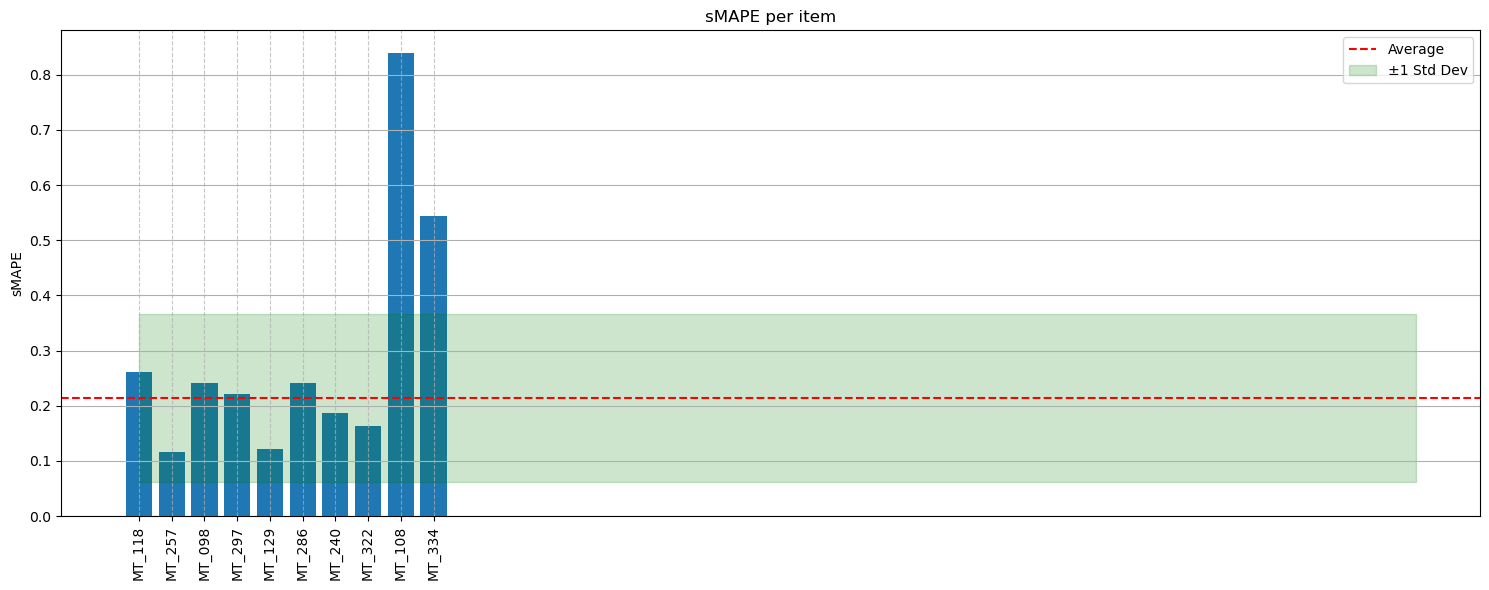

In [746]:
# display item-level metrics
item_metrics = pd.read_csv("output/item_metrics.csv.gz", compression="gzip")
visualize_item_metric(item_metrics, 'sMAPE')

### Deploy the model to a real-time endpoint

Now having a model version registered in the model registry, you can deploy this version as a SageMaker endpoint and run real-time inference.

#### Explore model registry

First take a look at the registered model version in the model package group. Open the link constructed by the following code cell and explore model version details.

In [750]:
# get the latest model version in the model package group
sm_model_package_data = boto3.client('sagemaker').list_model_packages(
    ModelPackageGroupName=model_package_group_name,
    SortBy="CreationTime",
    SortOrder="Descending",
)['ModelPackageSummaryList'][0]

In [756]:
# Show the model version link
display(
    HTML('<b>See <a target="top" href="https://studio-{}.studio.{}.sagemaker.aws/models/registered-models/{}/versions/version-{}/lineage">the model version lineage</a> in the Studio UI</b>'.format(
            domain_id, region, model_package_group_name, sm_model_package_data['ModelPackageVersion']))
)

#### Deploy the model

### Make predictions and visualize

---

## Further reading

GluonTS offers an advanced framework to create, train, and evaluate your own models. Refer to the GluonTS tutorial [Create your own model](https://ts.gluon.ai/stable/tutorials/forecasting/extended_tutorial.html#Create-your-own-model) for detailed documentation.

If you would like to run GluonTS training and predictions in a custom container, for example using SageMaker training or batch transform jobs, refer to this [sample Dockerfiles for GluonTS](https://github.com/awslabs/gluonts/tree/dev/examples/dockerfiles) GitHub repository.

You can find another example of productizaiton of GluonTS training in GitHub repository [Deep Demand Forecasting with Amazon SageMaker](https://github.com/awslabs/sagemaker-deep-demand-forecast). This example uses processing and training job with PyTorch estimator to imlement a training pipeline.

## Clean up

There is no resources in this notebook that need to be deleted.

---